
# Notebook `2_modeling.ipynb`

## Objetivo
Este notebook é a continuação do pipeline de dados e foca na etapa de modelagem preditiva. O objetivo é treinar e avaliar os modelos especialistas (condicional e orgânico) e, em seguida, utilizá-los para simular diferentes estratégias de negócio, culminando em uma análise de Retorno Sobre o Investimento (ROI).

O processo está estruturado da seguinte forma:
1.  **Configuração e Preparação:** Carregamento dos dados e definição das features que serão consideradas.
2.  **Pré-processamento:** Construção de um pipeline para preparar os dados para a modelagem.
3.  **Treinamento:** Treinamento dos modelos de "Gasto Condicional" e "Gasto Orgânico".
4.  **Avaliação Preditiva:** Análise da performance e da interpretabilidade de cada modelo.
5.  **Simulação de Resultados:** Execução de cenários de negócio e cálculo de impacto financeiro.

## Instruções de Uso
**Configuração Obrigatória:** Antes de executar o notebook, defina a variável `PATH_VOLUME` na célula 5. Este caminho será o diretório raiz onde todas as tabelas das camadas Bronze, Silver e Gold estão salvas e de onde serão lidas. Esta etapa foi desenvolvida no Databricks Free Edition, com o uso dos `Volumes`.

```PATH_VOLUME = "/Volumes/workspace/default/case_ifood"```


# Bibliotecas utilizadas

In [0]:
# Python
import math
from collections import defaultdict
from typing import List, Dict, Union, Optional, Any, Tuple

# Pyspark
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import Window

# Pré-processamento
from feature_engine.selection import DropConstantFeatures, SmartCorrelatedSelection
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

# Manipulação de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Modelagem
import shap
import optuna
import joblib
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, root_mean_squared_error


# Variáveis

In [0]:
# Importante mudar este caminho para o seu caso de uso
PATH_VOLUME = "/Volumes/workspace/default/case_ifood"

In [0]:
ID_FEATURES = [
    'account_id',
    'day'
]

TARGETS = [
    'spend_next_5d',
    'spend_next_10d'
]

OFFER_FEATURES = [
    # 'duration',
    'duration_range',
    # 'channel_web',
    # 'channel_email',
    # 'channel_mobile',
    # 'channel_social',
    'discount_value',
    # 'min_value',
    # 'offer_type',
    'incentive_type'
]

PROFILE_FEATURES = [
    'age_at_registration',
    'gender',
    'credit_card_limit',
    'relative_customer_tenure_days'
]

DROP_COLS = [
    'offer_id',
    'execution_date',
]

FEATURES = [
    'avg_ticket_last_10d',
    'avg_ticket_last_5d',
    'avg_ticket_last_7d',
    'avg_time_to_completion_last_10d',
    'avg_time_to_completion_last_5d',
    'avg_time_to_completion_last_7d',
    'bogo_transaction_count_last_10d',
    'bogo_transaction_count_last_5d',
    'bogo_transaction_count_last_7d',
    'count_bogo_offers_received_last_10d',
    'count_bogo_offers_received_last_5d',
    'count_bogo_offers_received_last_7d',
    'count_bogo_offers_viewed_last_10d',
    'count_bogo_offers_viewed_last_5d',
    'count_bogo_offers_viewed_last_7d',
    'count_high_inc_offers_received_last_10d',
    'count_high_inc_offers_received_last_5d',
    'count_high_inc_offers_received_last_7d',
    'count_high_inc_offers_viewed_last_10d',
    'count_high_inc_offers_viewed_last_5d',
    'count_high_inc_offers_viewed_last_7d',
    'count_info_offers_received_last_10d',
    'count_info_offers_received_last_5d',
    'count_info_offers_received_last_7d',
    'count_info_offers_viewed_last_10d',
    'count_info_offers_viewed_last_5d',
    'count_info_offers_viewed_last_7d',
    'count_long_offers_received_last_10d',
    'count_long_offers_received_last_5d',
    'count_long_offers_received_last_7d',
    'count_long_offers_viewed_last_10d',
    'count_long_offers_viewed_last_5d',
    'count_long_offers_viewed_last_7d',
    'count_low_inc_offers_received_last_10d',
    'count_low_inc_offers_received_last_5d',
    'count_low_inc_offers_received_last_7d',
    'count_low_inc_offers_viewed_last_10d',
    'count_low_inc_offers_viewed_last_5d',
    'count_low_inc_offers_viewed_last_7d',
    'count_offers_received_last_10d',
    'count_offers_received_last_5d',
    'count_offers_received_last_7d',
    'count_offers_viewed_last_10d',
    'count_offers_viewed_last_5d',
    'count_offers_viewed_last_7d',
    'count_short_offers_received_last_10d',
    'count_short_offers_received_last_5d',
    'count_short_offers_received_last_7d',
    'count_short_offers_viewed_last_10d',
    'count_short_offers_viewed_last_5d',
    'count_short_offers_viewed_last_7d',
    'count_unique_offers_received_last_10d',
    'count_unique_offers_received_last_5d',
    'count_unique_offers_received_last_7d',
    'count_unique_offers_viewed_last_10d',
    'count_unique_offers_viewed_last_5d',
    'count_unique_offers_viewed_last_7d',
    'days_since_last_offer_received',
    'days_since_last_transaction',
    'days_since_last_view',
    'discount_transaction_count_last_10d',
    'discount_transaction_count_last_5d',
    'discount_transaction_count_last_7d',
    'gov_sum_last_10d',
    'gov_sum_last_5d',
    'gov_sum_last_7d',
    'most_frequent_duration_received_last_10d',
    'most_frequent_duration_received_last_5d',
    'most_frequent_duration_received_last_7d',
    'most_frequent_duration_viewed_last_10d',
    'most_frequent_duration_viewed_last_5d',
    'most_frequent_duration_viewed_last_7d',
    'most_frequent_incentive_received_last_10d',
    'most_frequent_incentive_received_last_5d',
    'most_frequent_incentive_received_last_7d',
    'most_frequent_incentive_viewed_last_10d',
    'most_frequent_incentive_viewed_last_5d',
    'most_frequent_incentive_viewed_last_7d',
    'offer_transaction_count_last_10d',
    'offer_transaction_count_last_5d',
    'offer_transaction_count_last_7d',
    'offers_received_on_day',
    'organic_transaction_count_last_10d',
    'organic_transaction_count_last_5d',
    'organic_transaction_count_last_7d',
    'reward_sum_last_10d',
    'reward_sum_last_5d',
    'reward_sum_last_7d',
    'share_bogo_transactions_last_10d',
    'share_bogo_transactions_last_5d',
    'share_bogo_transactions_last_7d',
    'share_discount_transactions_last_10d',
    'share_discount_transactions_last_5d',
    'share_discount_transactions_last_7d',
    'sum_time_to_completion_last_10d',
    'sum_time_to_completion_last_5d',
    'sum_time_to_completion_last_7d',
    'transaction_count_last_10d',
    'transaction_count_last_5d',
    'transaction_count_last_7d',
    'usage_rate_from_received_last_10d',
    'usage_rate_from_received_last_5d',
    'usage_rate_from_received_last_7d',
    'usage_rate_from_viewed_last_10d',
    'usage_rate_from_viewed_last_5d',
    'usage_rate_from_viewed_last_7d',
    'view_rate_last_10d',
    'view_rate_last_5d',
    'view_rate_last_7d'
]

# Colunas da ABT 1 (Modelo com recebimento de oferta)
df_cols_1 = ID_FEATURES + TARGETS + OFFER_FEATURES + PROFILE_FEATURES + FEATURES

# Colunas da ABT 2 (Modelo sem recebimento de oferta)
df_cols_2 = ID_FEATURES + TARGETS + PROFILE_FEATURES + FEATURES


# A) Funções úteis

Para evitar a repetição de código e manter o foco na análise, as principais lógicas foram convertidas em funções. Elas estão agrupadas por tema nas seções a seguir para facilitar a consulta.


## A1) Pré-seleção de *features*
Antes da modelagem, faço uma *pré-seleção* de *features*, onde aplico alguns filtros como correlação, variância e *mutual information*. Abaixo estão as funções que aplicam esses filtros.

In [0]:
def drop_correlated_features_by_performance(
    dataframe: pd.DataFrame,
    feature_names: List[str],
    target_name: str,
    train_limit: float,
    correlation_threshold: float = 0.8,
) -> List[str]:
    """
    Realiza uma pré-seleção de features em duas etapas:
    1. Remove features quasi-constantes.
    2. Remove features altamente correlacionadas, mantendo a que contribui
       mais para a performance de um modelo CatBoost.

    Args:
        dataframe (pd.DataFrame): O DataFrame contendo todo o conjunto de dados.
        feature_names (List[str]): Uma lista com os nomes das colunas de features numéricas.
        target_name (str): O nome da coluna alvo (target).
        correlation_threshold (float, optional): O limiar de correlação para
            considerar features como altamente correlacionadas. Default é 0.8.
        test_size (float, optional): A proporção do dataset a ser usada para o
            conjunto de teste na divisão interna. Default é 0.3.

    Returns:
        List[str]: Uma lista com os nomes das features selecionadas.
    """
    print(f"Número inicial de features a considerar: {len(feature_names)}")

    # Separação dos dados para considerar apenas periodo de treino
    df_train = dataframe.loc[dataframe['day'] < train_limit]
    X = df_train[feature_names]
    y = df_train[target_name]

    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.3, random_state=42)

    # Remoção de features quasi-constantes (99%)
    constant_filter = DropConstantFeatures(tol=0.99, missing_values='include')
    constant_filter.fit(X_train)
    
    # Guarda as features a serem removidas antes de transformar o X_train
    features_to_drop_constant = constant_filter.features_to_drop_
    if features_to_drop_constant:
        print(f"\nFeatures removidas por serem constantes: {features_to_drop_constant}")
        X_train = constant_filter.transform(X_train)
        print(f"Número de features restantes: {X_train.shape[1]}")
    else:
        print("\nNenhuma feature constante encontrada.")

    # Remoção de features correlacionadas baseada em performance
    selection_estimator = CatBoostRegressor(iterations=50, verbose=0, random_seed=42)

    correlation_filter = SmartCorrelatedSelection(
        variables=None,
        method='pearson',
        threshold=correlation_threshold,
        selection_method='model_performance',
        estimator=selection_estimator,
        scoring='neg_mean_absolute_error',
        cv=3
    )

    print('\nIniciando processo de seleção de features correlacionadas...')
    correlation_filter.fit(X_train, y_train)
    
    features_to_drop_corr = correlation_filter.features_to_drop_
    if features_to_drop_corr:
        print(f"\nFeatures removidas por alta correlação: {features_to_drop_corr}")
        X_train = correlation_filter.transform(X_train)
        print(f"Número de features restantes: {X_train.shape[1]}")
    else:
        print("\nNenhuma feature altamente correlacionada encontrada para remover.")

    selected_features = list(X_train.columns)
    print(f"\nProcesso finalizado. {len(selected_features)} features foram selecionadas.")
    
    return selected_features


def select_categorical_features_by_mi(
    dataframe: pd.DataFrame,
    categorical_features: List[str],
    target_name: str,
    train_limit: int,
    mi_threshold: float = 0.01
) -> List[str]:
    """
    Seleciona features categóricas com base na pontuação de Informação Mútua (MI).

    A função primeiro codifica as features categóricas como inteiros e, em seguida,
    calcula a pontuação de Informação Mútua entre cada feature e a variável alvo.
    Apenas as features com uma pontuação acima do limiar (threshold) definido
    são retornadas.

    Args:
        dataframe (pd.DataFrame): O DataFrame contendo os dados.
        categorical_features (List[str]): Lista com os nomes das colunas categóricas.
        target_name (str): O nome da coluna alvo.
        mi_threshold (float, optional): O limiar mínimo de Informação Mútua para
            que uma feature seja selecionada. Default é 0.01.

    Returns:
        List[str]: Uma lista com os nomes das features categóricas selecionadas.
    """
    print("Iniciando seleção de features categóricas por Informação Mútua...")

    df_train = dataframe.loc[dataframe['day'] < train_limit]

    # Para o cálculo de MI, as categorias precisam ser convertidas em números.
    X_categorical_encoded = df_train[categorical_features].copy()
    for col in X_categorical_encoded.columns:
        X_categorical_encoded[col] = X_categorical_encoded[col].astype('category').cat.codes

    y_target = df_train[target_name]

    # Calcula MI
    mi_scores = mutual_info_regression(X_categorical_encoded, y_target, random_state=42)
    mi_scores_series = pd.Series(mi_scores, name="MI_Score", index=X_categorical_encoded.columns).sort_values(ascending=False)

    print("\nPontuação de Informação Mútua (Top 10):")
    print(mi_scores_series.head(10))

    # Seleciona apenas as features com MI score acima do limiar
    selected_features = mi_scores_series[mi_scores_series > mi_threshold].index.tolist()

    print(f"\nNúmero de features categóricas inicial: {len(categorical_features)}")
    print(f"Número de features categóricas selecionadas: {len(selected_features)}")
    
    return selected_features


## A2) Treino do modelo
Na modelagem, utilizei o Optuna para otimização de hiperparâmetros e seleção de variáveis com base na importância SHAP. Abaixo estão as funções de otimização e de treinamento do modelo final.

In [0]:
def calculate_regression_metrics(
    y_true: Union[pd.Series, np.ndarray],
    y_pred: Union[pd.Series, np.ndarray],
    prefix: str = 'val'
) -> Dict[str, float]:
    """
    Calcula e retorna um dicionário de métricas de avaliação para problemas de regressão.

    Args:
        y_true (Union[pd.Series, np.ndarray]): Os valores verdadeiros da variável alvo.
        y_pred (Union[pd.Series, np.ndarray]): Os valores previstos pelo modelo.
        prefix (str, optional): Um prefixo a ser adicionado no início de cadachave de métrica no dicionário.

    Returns:
        Dict[str, float]: Um dicionário contendo as métricas calculadas:
            - Mean Absolute Error (MAE)
            - Root Mean Squared Error (RMSE)
            - Median Absolute Error (MedianAE)
    """
    metrics = {
        f'{prefix}_mae': mean_absolute_error(y_true, y_pred),
        f'{prefix}_rmse': root_mean_squared_error(y_true, y_pred),
        f'{prefix}_median_ae': median_absolute_error(y_true, y_pred),
    }
    return metrics


def get_top_features_with_shap(
    X_features: pd.DataFrame,
    y_target: pd.Series,
    training_days: List[int],
    validation_days: List[int],
    days_column: pd.Series,
    num_features: int,
    categorical_features: List[str],
    features_to_exclude: Optional[List[str]] = None
) -> List[str]:
    """
    Seleciona as N features mais importantes usando os valores SHAP.

    A função treina um modelo CatBoost provisório em um conjunto de treino
    definido por 'training_days' e calcula os valores SHAP em um conjunto de
    validação definido por 'validation_days'. A importância de cada feature é
    determinada pela média de seus valores SHAP absolutos.

    Args:
        X_features (pd.DataFrame): DataFrame com todas as features candidatas.
        y_target (pd.Series): Series com a variável alvo.
        training_days (List[int]): Lista de dias para compor o conjunto de treino.
        validation_days (List[int]): Lista de dias para compor o conjunto de validação.
        days_column (pd.Series): A coluna de dias usada para fatiar os dados.
        num_features (int): O número de features a serem retornadas (top N).
        categorical_features (List[str]): Lista com os nomes das colunas categóricas.
        features_to_exclude (Optional[List[str]], optional): Lista de features a serem
            explicitamente removidas da seleção final. Default é None.

    Returns:
        List[str]: Uma lista com os nomes das N features mais importantes.
    """
    # Divisão dos dados em treino/validação com base nos dias
    train_mask = days_column.isin(training_days)
    validation_mask = days_column.isin(validation_days)

    X_train, y_train = X_features[train_mask], y_target[train_mask]
    X_validation = X_features[validation_mask]

    # Treinamento de um modelo provisório para extração de SHAP
    provisional_model = CatBoostRegressor(
        iterations=150,
        verbose=0,
        random_seed=42
    )
    provisional_model.fit(X_train, y_train, cat_features=categorical_features)

    # Cálculo dos valores SHAP
    explainer = shap.TreeExplainer(provisional_model)
    shap_values = explainer.shap_values(X_validation)

    # Agregação e ranqueamento das features
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'shap_importance': mean_abs_shap
    }).sort_values('shap_importance', ascending=False)

    # Exclusão de features indesejadas (se houver)
    if features_to_exclude:
        importance_df = importance_df.loc[
            ~importance_df['feature'].isin(features_to_exclude)
        ]

    # Seleção das N features mais importantes
    top_n_features = importance_df['feature'].head(num_features).tolist()

    return top_n_features


def find_best_model_with_optuna(
    dataframe: pd.DataFrame,
    candidate_features: List[str],
    categorical_features: List[str],
    target_name: str,
    cv_folds: List[Tuple[List[int], List[int]]],
    val_day: int,
    study_name: str,
    forced_features: Optional[List[str]] = None,
    n_trials: int = 50,
    overfitting_threshold: float = 1.5
) -> optuna.study.Study:
    """
    Executa um estudo Optuna completo para encontrar a melhor combinação de features
    e hiperparâmetros para um modelo CatBoostRegressor, usando validação cruzada
    com janela deslizante.

    A cada trial do Optuna, o processo é o seguinte:
    1. Sugere o número de features a serem selecionadas via SHAP.
    2. Sugere os hiperparâmetros para o modelo CatBoost.
    3. Realiza a seleção de features uma única vez em uma janela de tempo fixa.
    4. Treina e avalia o modelo com as features e hiperparâmetros selecionados
       através de todas as dobras (folds) da validação cruzada.
    5. Checa por overfitting. Se o erro de validação for muito maior que o de
       treino, o trial é penalizado (pruned).
    6. Retorna o erro médio de validação (MAE) como a métrica a ser otimizada.

    Args:
        dataframe (pd.DataFrame): O DataFrame completo com todos os dados.
        candidate_features (List[str]): Lista de todas as features candidatas
            para a seleção.
        categorical_features (List[str]): Lista de features categóricas dentro
            das candidatas.
        target_name (str): Nome da coluna alvo.
        cv_folds (List[Tuple[List[int], List[int]]]): Lista de tuplas, onde cada
            tupla contém (lista_de_dias_de_treino, lista_de_dias_de_validacao).
        val_day (int): O dia a ser utilizado como conjunto de validação para a
            etapa de seleção de features com SHAP.
        study_name (str): O nome do estudo Optuna, útil para identificação e
            armazenamento dos resultados.
        forced_features (Optional[List[str]], optional): Lista de features que
            DEVEM ser incluídas no modelo final, independentemente da seleção
            SHAP. Default é None.
        n_trials (int, optional): Número de trials a serem executados pelo Optuna.
            Default é 50.
        overfitting_threshold (float, optional): Multiplicador para a checagem de
            overfitting (val_mae > train_mae * threshold). Default é 1.5 (50%).

    Returns:
        optuna.study.Study: O objeto de estudo do Optuna completo, contendo
            todos os trials e resultados.
    """
    X = dataframe[candidate_features]
    y = dataframe[target_name]

    days_col = dataframe['day']

    # Seleciona os dias existentes no dataframe para treino e validação
    shap_train_days = sorted([x for x in days_col.drop_duplicates().tolist() if x < val_day])
    shap_val_day = [val_day]

    def objective(trial: optuna.Trial) -> float:
        # Hiperparâmetro para o número de features a selecionar via SHAP
        num_selected_features = trial.suggest_categorical('n_features', [5, 10, 15, 20, 25])
        
        # Hiperparâmetros do modelo CatBoost
        catboost_params = {
            'objective': 'MAE',
            'iterations': trial.suggest_int('iterations', 300, 1200),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 15.0, log=True),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
            'verbose': 0,
            'random_seed': 42
        }
        
        # Garante que forced_features seja uma lista vazia se for None
        features_to_force = forced_features or []
        
        top_features = get_top_features_with_shap(
            X, y, shap_train_days, shap_val_day, days_col, 
            num_selected_features, categorical_features, features_to_force
        )
        
        # Adiciona as features forçadas 
        final_feature_list = list(sorted(set(top_features + features_to_force)))
        final_cat_features = [col for col in final_feature_list if col in categorical_features]
        
        metrics_aggregator = defaultdict(list)

        # Loop da validação cruzada com janela deslizante
        for train_days, val_day in cv_folds:
            train_mask = days_col.isin(train_days)
            val_mask = days_col.isin(val_day)

            X_train_fold, X_val_fold = X[train_mask], X[val_mask]
            y_train_fold, y_val_fold = y[train_mask], y[val_mask]
            
            model = CatBoostRegressor(**catboost_params)
            model.fit(X_train_fold[final_feature_list], y_train_fold, cat_features=final_cat_features)
            
            y_pred_train = model.predict(X_train_fold[final_feature_list])
            y_pred_val = model.predict(X_val_fold[final_feature_list])
            
            train_metrics = calculate_regression_metrics(y_train_fold, y_pred_train, prefix='train')
            val_metrics = calculate_regression_metrics(y_val_fold, y_pred_val, prefix='val')
            
            for k, v in {**train_metrics, **val_metrics}.items():
                metrics_aggregator[k].append(v)
        
        # Agrega as métricas e checa overfitting
        avg_metrics = {k: np.mean(v) for k, v in metrics_aggregator.items()}
        
        # Interrompe trials que mostram overfitting
        if avg_metrics['val_mae'] > avg_metrics['train_mae'] * overfitting_threshold:
            raise optuna.exceptions.TrialPruned()
            
        # Salva metadados úteis no trial para análise posterior
        trial.set_user_attr('avg_metrics', avg_metrics)
        trial.set_user_attr('selected_features_count', num_selected_features)
        trial.set_user_attr('selected_features_list', final_feature_list)
        trial.set_user_attr('selected_cat_cols_list', final_cat_features)

        return avg_metrics['val_mae']

    # Cria e executa o estudo Optuna
    study = optuna.create_study(direction='minimize', study_name=study_name)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    return study


def train_and_evaluate_final_model(
    study: optuna.study.Study,
    dataframe: pd.DataFrame,
    target_name: str,
    test_day: int,
    day_column_name: str = 'day'
) -> Tuple[CatBoostRegressor, Dict[str, float]]:
    """
    Treina o modelo final com os melhores parâmetros encontrados pelo Optuna e o
    avalia em um conjunto de teste (holdout) definido por um dia específico.

    Args:
        study (optuna.study.Study): O objeto de estudo do Optuna já executado.
        dataframe (pd.DataFrame): O DataFrame completo para treino e teste.
        target_name (str): O nome da coluna da variável alvo.
        test_day (int): O dia que será usado como conjunto de teste (holdout).
            Todos os dias anteriores serão usados para o treino final.
        day_column_name (str, optional): O nome da coluna que contém a informação
            dos dias. O padrão é 'day'.

    Returns:
        Tuple[CatBoostRegressor, Dict[str, float]]: Uma tupla contendo:
            - O objeto do modelo final CatBoost treinado.
            - Um dicionário com as métricas de performance no conjunto de teste.
    """

    # Extrai os melhores parâmetros e a lista de features do estudo
    best_trial = study.best_trial
    best_params = best_trial.params.copy()
    best_params.pop('n_features', None)

    best_features_list = best_trial.user_attrs['selected_features_list']
    best_cat_cols_list = best_trial.user_attrs['selected_cat_cols_list']
    
    print(f"Trial vencedor: #{best_trial.number}")
    print(f"Número de features selecionadas: {len(best_features_list)}")

    # Divide os dados em treino final e teste (holdout)
    df_train_final = dataframe[dataframe[day_column_name] < test_day].copy()
    df_test_final = dataframe[dataframe[day_column_name] == test_day].copy()

    X_train = df_train_final[best_features_list]
    y_train = df_train_final[target_name]
    X_test = df_test_final[best_features_list]
    y_test = df_test_final[target_name]

    # Treina o modelo final com todos os dados de treino e os melhores parâmetros
    final_model = CatBoostRegressor(**best_params, verbose=0, random_seed=42)
    final_model.fit(X_train, y_train, cat_features=best_cat_cols_list)

    # Faz predições no conjunto de teste e calcula as métricas
    # Garante que predições de gasto não sejam negativas
    predictions = np.maximum(0, final_model.predict(X_test))
    
    final_metrics = calculate_regression_metrics(y_test, predictions, prefix='holdout_test')

    print("\nMétricas Finais no Conjunto de Teste")
    for metric, value in final_metrics.items():
        print(f"  {metric}: {value:.4f}")
    
    return final_model, X_test, y_test, predictions


## A3) *Plots* e Avaliação do Modelo
Aqui estão as funções para gerar os plots de análises, como: importância de features, SHAP, *gains chart*, etc.

In [0]:
def plot_feature_importance(
    model: CatBoostRegressor,
    model_name: str,
    top_n: Optional[int] = None
) -> None:
    """
    Calcula e plota a importância de features nativa de um modelo CatBoost treinado.

    A função extrai a importância e os nomes das features do objeto do modelo,
    cria um DataFrame, ordena os resultados e gera um gráfico de barras horizontais.

    Args:
        model (CatBoostRegressor): O modelo CatBoost já treinado.
        top_n (Optional[int], optional): O número de features mais importantes a serem
            exibidas no gráfico. Se o valor for None, todas as features do modelo
            serão plotadas. O padrão é None.

    Returns:
        None: A função exibe um gráfico matplotlib e não retorna nenhum objeto.
    """
    # Extrai a importância e os nomes das features do modelo
    feature_importances = model.get_feature_importance()
    feature_names = model.feature_names_

    # Cria e ordena o DataFrame de importância
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values('importance', ascending=False)

    if top_n is None:
        data_to_plot = importance_df
        plot_title = f'Importância de todas as features ({model_name})'
        num_features_for_plot = len(importance_df)
    else:
        # Usa o top N especificado
        data_to_plot = importance_df.head(top_n)
        plot_title = f'Top {top_n} features mais importantes ({model_name})'
        num_features_for_plot = top_n

    # Configura e gera o gráfico
    sns.set_style('whitegrid')
    fig_height = max(1, num_features_for_plot / 2.5)
    plt.figure(figsize=(10, fig_height))
    
    sns.barplot(x='importance', y='feature', data=importance_df.head(top_n))
    
    plt.title(plot_title, fontsize=16)
    plt.xlabel('Importância', fontsize=12)
    plt.ylabel('')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


def calculate_shap_values(
    model: CatBoostRegressor,
    features_df: pd.DataFrame
) -> Tuple[shap.TreeExplainer, np.ndarray]:
    """
    Calcula os valores SHAP para um determinado modelo e conjunto de dados.

    Args:
        model (CatBoostRegressor): O modelo tree-based (CatBoost) já treinado.
        features_df (pd.DataFrame): O conjunto de dados (X_test) para o qual
            os valores SHAP serão calculados.

    Returns:
        Tuple[shap.TreeExplainer, np.ndarray]: Uma tupla contendo:
            - O objeto explainer do SHAP.
            - Um array NumPy com os valores SHAP calculados.
    """
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(features_df)
    
    return explainer, shap_values


def plot_shap_summary_from_values(
    shap_values: np.ndarray,
    features_df: pd.DataFrame,
    model_name: Optional[str] = None
) -> None:
    """
    Exibe um gráfico de resumo SHAP (summary plot) a partir de valores já calculados.

    Args:
        shap_values (np.ndarray): O array de valores SHAP, geralmente o output de
            `explainer.shap_values()`.
        features_df (pd.DataFrame): O DataFrame de features correspondente aos
            valores SHAP (precisa ter a mesma ordem de colunas e linhas).
        model_name (Optional[str], optional): Um nome para o modelo a ser exibido
            no título do gráfico para diferenciação. O padrão é None.

    Returns:
        None: A função exibe um gráfico matplotlib e não retorna nenhum objeto.
    """

    if model_name:
        plot_title = f'Impacto SHAP das features na predição ({model_name})'
    else:
        plot_title = 'Impacto SHAP das features na predição'

    plt.title(plot_title, fontsize=16)
    
    shap.summary_plot(shap_values, features_df, show=False)
    
    plt.tight_layout()
    plt.show()


def plot_shap_dependence_grid(
    shap_values: np.ndarray,
    features_df: pd.DataFrame,
    features_to_plot: List[str],
    categorical_features: Optional[List[str]] = None,
    model_name: Optional[str] = None
) -> None:
    """
    Cria uma grade de gráficos de dependência SHAP, ordenados por importância,
    com tratamento especial para features categóricas.

    Args:
        shap_values (np.ndarray): O array de valores SHAP.
        features_df (pd.DataFrame): O DataFrame de features correspondente.
        features_to_plot (List[str]): Lista de features para as quais os
            gráficos serão gerados. A ordem não importa.
        categorical_features (Optional[List[str]], optional): Lista com os nomes
            das features que devem ser tratadas como categóricas no plot.
            Default é None.
        model_name (Optional[str], optional): Um nome para o modelo, a ser
            exibido no título geral da figura. O padrão é None.

    Returns:
        None: A função exibe uma figura matplotlib e não retorna nenhum objeto.
    """
    sns.set_style('whitegrid')
    
    # Garante que a lista de categóricas não seja None para a verificação `in`
    if categorical_features is None:
        categorical_features = []

    # Calcula a importância global para definir a ordem de plotagem
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    importance_df = pd.DataFrame({
        'feature': features_df.columns,
        'importance': mean_abs_shap
    })
    ordered_features = (
        importance_df[importance_df['feature'].isin(features_to_plot)]
        .sort_values('importance', ascending=False)['feature']
        .tolist()
    )
    
    # Calcula as dimensões e cria a grade
    num_features = len(ordered_features)
    num_cols = 2
    num_rows = math.ceil(num_features / num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 6))
    axes = axes.flatten()

    if model_name:
        fig.suptitle(
            f'Gráficos de Dependência SHAP ({model_name})',
            fontsize=20, y=1.0002
        )

    # Itera sobre a lista ordenada para criar cada plot
    for i, feature in enumerate(ordered_features):
        ax = axes[i]
        feature_index = features_df.columns.get_loc(feature)
        
        shap.dependence_plot(
            feature_index, shap_values, features_df, ax=ax, interaction_index=feature, show=False
        )

        # Customiza cada subplot
        ax.set_title(f'Feature #{i + 1}: {feature.upper()}', fontsize=14, fontweight='bold', pad=10)
        ax.set_ylabel('Valor SHAP', fontsize=10, labelpad=.5)
        ax.set_xlabel('')
        ax.tick_params(axis='both', labelsize=10)
        ax.axhline(0, color='red', linestyle='-', linewidth=1.2)
        
        # Tratamento de Eixo Específico por Tipo de Feature
        if feature not in categorical_features:
            ax.xaxis.set_major_locator(MaxNLocator(nbins=10, prune='both'))

    # Esconde os eixos não utilizados
    for j in range(num_features, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()


def plot_error_analysis_by_bin(
    y_true: pd.Series,
    y_pred: np.ndarray,
    num_bins: int = 5,
    model_name: Optional[str] = None
) -> pd.DataFrame:
    """
    Analisa e plota o erro de um modelo, agrupado por faixas de predição.

    A função executa os seguintes passos:
    1. Cria um DataFrame com valores reais e previstos.
    2. Remove outliers, considerando apenas o intervalo interpercentil [1%, 99%]
       dos valores reais.
    3. Calcula o erro absoluto para os dados filtrados.
    4. Agrupa as predições em N faixas (bins) de mesmo tamanho (quantis).
    5. Calcula o MAE e o Erro Absoluto Mediano para cada faixa.
    6. Plota um gráfico de barras lado a lado comparando as duas métricas.

    Args:
        y_true (pd.Series): Os valores verdadeiros da variável alvo.
        y_pred (np.ndarray): Os valores previstos pelo modelo.
        num_bins (int, optional): O número de faixas (bins) para agrupar as
            predições. O padrão é 5.
        model_name (Optional[str], optional): Um nome para o modelo, a ser
            exibido no título do gráfico. O padrão é None.

    Returns:
        pd.DataFrame: Um DataFrame com as métricas de erro agregadas por faixa.
    """
    # Cria DataFrame inicial com resultados
    results_df = pd.DataFrame({
        'actual': y_true,
        'predicted': y_pred
    })

    # Filtra outliers com base nos percentis 1 e 99 dos valores reais
    lower_bound = results_df['actual'].quantile(0.01)
    upper_bound = results_df['actual'].quantile(0.99)
    results_df_filtered = results_df[results_df['actual'].between(lower_bound, upper_bound)].copy()

    # Calcula o erro absoluto nos dados filtrados
    results_df_filtered['error'] = results_df_filtered['actual'] - results_df_filtered['predicted']
    results_df_filtered['abs_error'] = np.abs(results_df_filtered['actual'] - results_df_filtered['predicted'])

    # Agrupa as predições em faixas (bins)
    results_df_filtered['prediction_bin'] = pd.qcut(results_df_filtered['predicted'], q=num_bins, duplicates='drop')

    # Agrega as métricas por faixa, incluindo o erro mediano
    error_by_bin = (
        results_df_filtered
        .groupby('prediction_bin', observed=False)
        .agg(
            count=('actual', 'size'),
            avg_prediction=('predicted', 'mean'),
            avg_actual=('actual', 'mean'),
            mae=('abs_error', 'mean'),
            median_ae=('abs_error', 'median')
        )
        .sort_index()
    )

    # Formata o índice para melhor legibilidade no gráfico
    error_by_bin.index = [f'R\\${interval.left:.2f} a R\\${interval.right:.2f}' for interval in error_by_bin.index]

    # Gera o gráfico de barras lado a lado
    sns.set_style('whitegrid')
    ax = error_by_bin[['mae', 'median_ae']].plot(
        kind='bar',
        figsize=(12, 7),
        edgecolor='black',
        width=0.8,
        color=["#EA1D2C", "#F7ACB7"]
    )

    # Customiza o gráfico
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', fontsize=9, padding=3, fontweight='bold')

    title = f'Análise de Erro por Faixa de Predição ({model_name})' if model_name else 'Análise de Erro por Faixa de Predição'
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_xlabel('Faixa de Valor Predito', fontsize=12, fontweight='bold', labelpad=15)
    ax.set_ylabel('Erro Absoluto', fontsize=12, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=11)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Ajusta o limite do eixo Y para acomodar os rótulos
    max_error = error_by_bin[['mae', 'median_ae']].max().max()
    ax.set_ylim(0, max_error * 1.8)
    
    ax.legend(['Erro Médio (MAE)', 'Erro Mediano'], title='Métrica de Erro', fontsize=12, title_fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return results_df_filtered


def plot_residuals_distribution(
    results_df: pd.DataFrame,
    bins: int = 30,
    model_name: Optional[str] = None
) -> None:
    """
    Plota um histograma da distribuição dos erros de predição (resíduos).

    Um bom modelo de regressão geralmente apresenta resíduos distribuídos
    normalmente em torno de zero. Esta visualização ajuda a verificar essa premissa.

    Args:
        results_df (pd.DataFrame): DataFrame que deve conter uma coluna chamada 'error'
            com os resíduos calculados (Real - Predito).
        bins (int, optional): O número de bins para o histograma. O padrão é 30.
        model_name (Optional[str], optional): Um nome para o modelo, a ser
            exibido no título do gráfico para diferenciação. O padrão é None.

    Returns:
        None: A função exibe um gráfico matplotlib e não retorna nenhum objeto.
    """
    # Validação para garantir que a coluna necessária existe
    if 'error' not in results_df.columns:
        raise ValueError("O DataFrame de entrada deve conter uma coluna 'error'.")

    sns.set_style('whitegrid')
    plt.figure(figsize=(10, 6))

    sns.histplot(results_df['error'], kde=True, bins=bins)

    # Customização
    title = f'Distribuição dos Resíduos ({model_name})' if model_name else 'Distribuição dos Resíduos'
    plt.title(title, fontsize=14, fontweight='bold', pad=10)
    plt.xlabel('Erro (Real - Predito)', fontsize=11, fontweight='bold')
    plt.ylabel('Frequência', fontsize=11, fontweight='bold')
    
    # Adiciona uma linha vertical em x=0 para referência de erro zero
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5, label='Erro Zero')
    
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_decision_shap_for_highest_prediction(
    explainer: shap.TreeExplainer,
    shap_values: np.ndarray,
    features_df: pd.DataFrame,
    results_df: pd.DataFrame,
    model_name: Optional[str] = None
) -> None:
    """
    Plota um SHAP Decision Plot para o caso com a maior predição no conjunto de resultados.

    Args:
        explainer (shap.TreeExplainer): O objeto explainer do SHAP já treinado.
        shap_values (np.ndarray): O array de valores SHAP para o conjunto de dados.
        features_df (pd.DataFrame): O DataFrame de features (e.g., X_test)
            correspondente aos valores SHAP.
        results_df (pd.DataFrame): DataFrame com a coluna 'predicted',
            e com o mesmo índice que `features_df`.
        model_name (Optional[str], optional): Um nome para o modelo, a ser
            exibido no título do gráfico. O padrão é None.

    Returns:
        None: A função exibe um gráfico matplotlib e não retorna nenhum objeto.
    """
    try:
        # Identificar o índice do caso com a maior predição
        idx_highest = results_df['predicted'].idxmax()
        highest_pred_value = results_df.loc[idx_highest, 'predicted']

        # Encontrar a posição (iloc) desse índice para alinhar com o array SHAP
        pos_highest = features_df.index.get_loc(idx_highest)

        # Fatiar os dados e os valores SHAP para este único caso
        shap_values_subset = shap_values[[pos_highest], :]
        features_subset = features_df.loc[[idx_highest]]

        # Gerar o Decision Plot
        model_name = f' ({model_name})' if model_name else ''
        plot_title = (
            f'Decision Plot: Maior Predição{model_name}'
            f'(R\\$ {highest_pred_value:.2f})'
        )

        shap.decision_plot(
            base_value=explainer.expected_value,
            shap_values=shap_values_subset,
            features=features_subset,
            feature_names=features_df.columns.tolist(),
            show=False
        )
        
        plt.title(plot_title, fontsize=16)
        plt.tight_layout()
        plt.show()

    except (IndexError, KeyError, ValueError) as e:
        print(f"Não foi possível gerar o SHAP Decision Plot: {e}")


from typing import Union, Optional
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_gains_chart(
    y_true: Union[pd.Series, np.ndarray],
    y_pred: Union[pd.Series, np.ndarray],
    title: str = 'Gráfico de Ganhos Cumulativos',
    highlight_percentile: Optional[int] = 30
) -> None:
    """
    Plota um Gráfico de Ganhos Cumulativos para avaliar a performance de um modelo.

    O gráfico mostra a porcentagem do valor total real (e.g., gastos) que é
    capturada ao selecionar uma certa porcentagem da população, ordenada pelas
    maiores predições do modelo.

    Args:
        y_true (Union[pd.Series, np.ndarray]): Os valores reais da variável alvo.
        y_pred (Union[pd.Series, np.ndarray]): Os valores previstos pelo modelo.
        title (str, optional): O título do gráfico.
        highlight_percentile (Optional[int], optional): O percentil da população
            a ser destacado no gráfico (e.g., 30 para o top 30%). Se None,
            nenhum destaque é feito. O padrão é 30.
    """
    if len(y_true) != len(y_pred):
        raise ValueError("y_true e y_pred devem ter o mesmo tamanho.")

    # Cria um DataFrame e ordena pelas predições (da maior para a menor)
    results_df = pd.DataFrame({'actual': y_true, 'predicted': y_pred})
    results_df = results_df.sort_values(by='predicted', ascending=False)

    # Calcula os ganhos cumulativos
    total_actual_sum = results_df['actual'].sum()
    results_df['cumulative_gain'] = 100 * results_df['actual'].cumsum() / total_actual_sum
    
    # Calcula o percentil da população
    results_df['population_percent'] = 100 * (np.arange(1, len(results_df) + 1) / len(results_df))

    # Configura e gera o gráfico
    sns.set_style('whitegrid')
    plt.figure(figsize=(8, 8))

    # Curva do Modelo
    plt.plot(results_df['population_percent'], results_df['cumulative_gain'], label='Modelo', lw=2)
    
    # Linha de Base (modelo aleatório)
    plt.plot([0, 100], [0, 100], label='Linha de Base (Aleatório)', color='grey', linestyle='--', lw=2)

    # Destaque do percentil (se especificado)
    if highlight_percentile is not None and 0 < highlight_percentile < 100:
        # Encontra o valor do ganho no percentil especificado
        idx = int(len(results_df) * (highlight_percentile / 100)) - 1
        gain_at_percentile = results_df[results_df['population_percent'] <= highlight_percentile]['cumulative_gain'].iloc[-1]
        
        # Plota as linhas de destaque
        plt.plot([highlight_percentile, highlight_percentile], [highlight_percentile, gain_at_percentile], 'r--', linewidth=1.5)
        plt.plot([0, highlight_percentile], [gain_at_percentile, gain_at_percentile], 'r--', linewidth=1.5)
        
        # Adiciona o texto de anotação
        plt.text(
            highlight_percentile + 2,
            gain_at_percentile - 10,
            f'Top {highlight_percentile}% da população\n'
            f'captura {gain_at_percentile:.1f}% do valor total',
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.8),
            fontweight='bold'
        )

    # Customização final
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('% da População (ordenada pela predição do modelo)', fontsize=12, fontweight='bold')
    plt.ylabel('% Cumulativo do Valor Total', fontsize=12, fontweight='bold')
    plt.xticks([x for x in range(0, 101, 10)])
    plt.yticks([x for x in range(0, 101, 10)])
    plt.legend(loc='lower right', fontsize=12)
    plt.axis([0, 100, 0, 100])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_decile_analysis(
    y_true: Union[pd.Series, np.ndarray],
    y_pred: Union[pd.Series, np.ndarray],
    model_name: Optional[str] = None
) -> pd.DataFrame:
    """
    Realiza uma análise por decil e plota um gráfico de barras comparativo
    entre o valor médio real e o valor médio predito para cada decil.

    A função executa os seguintes passos:
    1. Filtra outliers, considerando apenas o intervalo interpercentil [1%, 99%]
       dos valores reais (`y_true`).
    2. Segmenta a população em 10 grupos (decis) com base nos valores preditos.
    3. Calcula a média dos valores reais e preditos para cada decil.
    4. Plota um gráfico de barras estilizado para comparar esses valores.

    Args:
        y_true (Union[pd.Series, np.ndarray]): Os valores reais da variável alvo.
        y_pred (Union[pd.Series, np.ndarray]): Os valores preditos pelo modelo.
        model_name (Optional[str], optional): Um nome para o modelo, a ser
            exibido no título do gráfico. O padrão é None.

    Returns:
        pd.DataFrame: Um DataFrame com a análise agregada por decil.
    """
    sns.set_style('whitegrid')
    
    # Cria um DataFrame com os resultados
    results_df = pd.DataFrame({'actual': y_true, 'predicted': y_pred})

    # Remove outliers com base nos valores reais
    lower_bound = results_df['actual'].quantile(0.01)
    upper_bound = results_df['actual'].quantile(0.99)
    results_df_filtered = results_df[results_df['actual'].between(lower_bound, upper_bound)].copy()

    # Cria os decis (10 = Top 10% de maiores predições)
    results_df_filtered['decile'] = pd.qcut(results_df_filtered['predicted'], 10, labels=False, duplicates='drop') + 1

    # Agrega os valores por decil
    decile_analysis = results_df_filtered.groupby('decile').agg(
        avg_actual=('actual', 'mean'),
        avg_predicted=('predicted', 'mean')
    ).sort_index(ascending=False)

    # Plota o gráfico
    ax = decile_analysis.plot(
        kind='bar',
        figsize=(14, 8),
        color=["#EA1D2C", "#F7ACB7"],
        width=0.9,
        edgecolor='black'
    )

    # Customiza o gráfico
    for container in ax.containers:
        ax.bar_label(
            container,
            fmt='R\\$%.2f',
            fontsize=9,
            padding=3,
            fontweight='bold'
        )

    # Ajusta o eixo Y dinamicamente
    max_y_value = decile_analysis.max().max()
    ax.set_ylim(0, max_y_value * 1.18)

    # Define o título
    title = f'Valor Médio Real vs. Predito por Decil ({model_name})' if model_name else 'Valor Médio Real vs. Predito por Decil'
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    
    ax.set_xlabel('Decil de Predição (10 = Top 10% com maior predição)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Valor Médio Gasto', fontsize=12, fontweight='bold')
    plt.xticks(rotation=0, fontsize=10)
    plt.yticks(fontsize=10)
    ax.legend(['Valor Real Médio', 'Valor Predito Médio'], fontsize=13)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return decile_analysis


# 1) Modelo de Gasto Condicional
Este é o primeiro dos nossos dois modelos especialistas e sua principal função é entender e prever o comportamento futuro de um cliente dado que ele recebeu uma oferta.

## Premissas de Construção
- **Universo de Dados:** O modelo é treinado exclusivamente com dados de dias em que os clientes **receberam uma oferta**.
- **Objetivo:** O foco é aprender a relação entre o perfil histórico do cliente, as características da oferta que ele recebeu e o seu comportamento futuro de compra.

## Variável Alvo (O que o modelo prevê?)
- O modelo foi treinado para prever o **valor total do gasto (`spend_next_5d`)** de um cliente durante os **próximos 5 dias**, contados a partir do dia em que a oferta foi recebida.

---

**Justificativa da escolha da target:**  
A princípio, a *target* de 10 dias foi considerada. No entanto, essa definição reduziria significativamente a amostra utilizável, pois a base vai apenas até o dia 29 (após agregarmos as variáveis), limitando o uso dos dados até o dia 19. Para evitar essa perda relevante de observações, optou-se por definir a *target* como o gasto nos próximos 5 dias.

In [0]:
# Dia reservado para validação final do modelo
TEST_DAY = 24

TARGET_NAME = 'spend_next_5d'

In [0]:
df = pd.read_parquet(f"{PATH_VOLUME}/gold/abt_offer")[df_cols_1]

# O discount_value apesar de ser uma variável float, será tratada como string
df[OFFER_FEATURES] = df[OFFER_FEATURES].astype('str')

# Como a target são 5 dias, só podemos olhar até o dia 24 (29 - 5 = 24)
df = df.loc[df['day'] <= 24]

# Separa features numéricas das categóricas (importante para o catboost)
df_types = df[FEATURES + PROFILE_FEATURES].dtypes.reset_index(name='data_type')
num_cols = df_types.loc[df_types['data_type'] != 'object']['index'].tolist()
cat_cols = df_types.loc[df_types['data_type'] == 'object']['index'].tolist()


## 1.1) Pré-seleção de *features*
Antes de treinar os modelos finais, realizamos um processo de pré-seleção de features. O objetivo é reduzir a dimensionalidade, eliminando variáveis com baixo poder preditivo ou que são redundantes, reduzindo o tempo de treino nas etapas seguintes.

A seleção foi dividida em três etapas principais:
1.  **Remoção de Features Quase Constantes:**
    Foram removidas todas as variáveis que apresentam o mesmo valor em 99% ou mais das amostras (incluindo valores nulos). Essas features carregam pouquíssima informação (há ressalvas sobre isso, porém por conta do tempo decidi tirá-las).

2.  **Remoção de Features Numéricas Correlacionadas:**
    Para as variáveis numéricas, identificamos pares com alta correlação (coeficiente de Pearson > 0.8). Para decidir qual feature do par seria descartada, utilizamos uma abordagem baseada em performance: um modelo CatBoost preliminar foi treinado, e a feature que demonstrou ser menos importante para a predição do modelo foi removida, preservando assim a variável de maior valor preditivo.

3.  **Seleção de Features Categóricas por Informação Mútua:**
    Para as variáveis categóricas, a seleção foi feita com base na pontuação de "Informação Mútua" em relação à target. Esta métrica quantifica a dependência entre a feature e a target. Variáveis com uma pontuação abaixo de um limiar predefinido foram consideradas de baixo impacto e, portanto, descartadas.

In [0]:
selected_num_cols = drop_correlated_features_by_performance(
    dataframe = df,
    feature_names = num_cols,
    target_name = TARGET_NAME,
    train_limit = 14,
    correlation_threshold = 0.8
)

Número inicial de features a considerar: 100

Features removidas por serem constantes: ['count_bogo_offers_received_last_5d', 'count_high_inc_offers_received_last_5d', 'count_high_inc_offers_viewed_last_5d', 'count_info_offers_received_last_5d', 'count_long_offers_received_last_5d', 'count_low_inc_offers_received_last_5d', 'count_offers_received_last_5d', 'count_short_offers_received_last_5d', 'count_unique_offers_received_last_5d', 'offers_received_on_day', 'usage_rate_from_received_last_5d', 'view_rate_last_5d']
Número de features restantes: 88

Iniciando processo de seleção de features correlacionadas...

Features removidas por alta correlação: ['avg_ticket_last_5d', 'avg_ticket_last_7d', 'gov_sum_last_10d', 'gov_sum_last_7d', 'avg_time_to_completion_last_5d', 'avg_time_to_completion_last_7d', 'sum_time_to_completion_last_10d', 'sum_time_to_completion_last_5d', 'sum_time_to_completion_last_7d', 'bogo_transaction_count_last_10d', 'bogo_transaction_count_last_7d', 'reward_sum_last_10d

In [0]:
selected_cat_cols = select_categorical_features_by_mi(
    dataframe = df,
    categorical_features = cat_cols,
    target_name = TARGET_NAME,
    train_limit = 14,
    mi_threshold = 0.01
) + OFFER_FEATURES

Iniciando seleção de features categóricas por Informação Mútua...

Pontuação de Informação Mútua (Top 10):
gender                                      0.073719
most_frequent_duration_viewed_last_7d       0.009598
most_frequent_incentive_received_last_5d    0.004945
most_frequent_incentive_viewed_last_5d      0.004034
most_frequent_duration_received_last_5d     0.002588
most_frequent_duration_viewed_last_10d      0.001108
most_frequent_incentive_viewed_last_7d      0.000344
most_frequent_duration_received_last_10d    0.000000
most_frequent_duration_received_last_7d     0.000000
most_frequent_duration_viewed_last_5d       0.000000
Name: MI_Score, dtype: float64

Número de features categóricas inicial: 13
Número de features categóricas selecionadas: 1


In [0]:
selected_features = selected_num_cols + selected_cat_cols


## 1.2) Treinamento e Otimização do Modelo com Optuna
Nesta etapa, utilizamos a biblioteca `Optuna` para conduzir um processo automatizado de busca pela melhor configuração do nosso modelo. O objetivo não é apenas encontrar os melhores hiperparâmetros, mas também o subconjunto de features mais preditivo, em um processo de otimização conjunta.

A metodologia foi estruturada da seguinte forma:

### Estratégia de Validação Cruzada Temporal (*Sliding Window*)
Para garantir que o modelo seja robusto e capaz de generalizar para dados futuros, adotamos uma estratégia de validação cruzada que simula o avanço do tempo.

- **Conjunto de Holdout:** Primeiramente, o dia final de teste (`day=24`) é completamente removido do processo de treinamento e otimização. Ele será usado apenas uma vez, ao final de tudo, para validar a performance do modelo campeão.
- **Janelas Deslizantes (Folds):** Construímos 3 "folds" temporais. Em cada fold, o modelo é treinado com os dados disponíveis até uma certa semana e validado na semana seguinte. Isso nos permite avaliar a performance do modelo em diferentes períodos de tempo.
- **Métrica de Avaliação:** A performance de cada configuração testada pelo Optuna é medida pelo **erro médio absoluto (MAE)**, calculado como a média dos MAEs obtidos em cada um dos 3 folds de validação.

### Processo de Otimização (A cada *trial* do Optuna)
Para cada uma das tentativas (`trials`) que o Optuna executa, o seguinte processo ocorre:

1.  **Seleção de Features Dinâmica via SHAP:**
    - O Optuna primeiro sugere um **número de features** a serem testadas (5, 10, 15 ou 20).
    - Um modelo CatBoost preliminar é treinado rapidamente com **todas** as features pré-selecionadas.
    - Os valores **SHAP** são calculados para ranquear a importância de cada feature.
    - As **top N features** (onde N foi o número sugerido pelo Optuna) são selecionadas para prosseguir para a próxima etapa.

2.  **Otimização de Hiperparâmetros:**
    - O Optuna sugere um conjunto de **hiperparâmetros** para o CatBoost (`learning_rate`, `depth`, etc.).
    - Um novo modelo é treinado e avaliado usando a validação cruzada temporal, mas desta vez **apenas com o subconjunto de features selecionado** na etapa anterior.

3.  **Prevenção de Overfitting:**
    - Ao final da avaliação nos folds, comparamos o MAE médio de validação com o MAE médio de treino.
    - Se o erro de validação for **50% maior** que o erro de treino, consideramos que o modelo está sofrendo overfitting. Nesse caso, o Optuna descarta (`prune`) essa combinação de parâmetros e features, garantindo que apenas modelos robustos sejam considerados.

In [0]:
# Reserva o ultimo dia para teste out-of-time final
df_modeling = df[df['day'] <= TEST_DAY].copy()

# Pega os dias únicos para fazer a validação cruzada
hpo_days = sorted([d for d in df_modeling['day'].unique() if d < TEST_DAY])
df_hpo = df_modeling[df_modeling['day'].isin(hpo_days)]

# Cada modelo vai ser treinado 3 vezes, com janelas deslizantes. Exemplo: Treino com [0, 7] e Validação com [14]
folds = [
    (hpo_days[:-3], [hpo_days[-3]]),
    (hpo_days[:-2], [hpo_days[-2]]),
    (hpo_days[:-1], [hpo_days[-1]])
]

In [0]:
# Roda o estudo do optuna para otimização de hiperparâmetros (seleção de features já inclusa)
study_results_1 = find_best_model_with_optuna(
    dataframe=df_hpo,
    candidate_features=selected_features,
    categorical_features=selected_cat_cols,
    target_name=TARGET_NAME,
    cv_folds=folds,
    val_day=21,
    study_name='Catboost_model_1_hpo',
    forced_features=OFFER_FEATURES,
    n_trials=20,
    overfitting_threshold=1.5
)

[I 2025-09-30 03:33:51,763] A new study created in memory with name: Catboost_model_1_hpo


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-09-30 03:34:49,552] Trial 0 finished with value: 17.2014177196136 and parameters: {'n_features': 15, 'iterations': 1178, 'learning_rate': 0.07726134142476035, 'depth': 5, 'l2_leaf_reg': 6.411166696228949, 'colsample_bylevel': 0.9850598496558465}. Best is trial 0 with value: 17.2014177196136.
[I 2025-09-30 03:35:08,541] Trial 1 finished with value: 19.135831087342638 and parameters: {'n_features': 15, 'iterations': 407, 'learning_rate': 0.0019660123122591964, 'depth': 4, 'l2_leaf_reg': 6.128768580121916, 'colsample_bylevel': 0.684764073523677}. Best is trial 0 with value: 17.2014177196136.
[I 2025-09-30 03:36:22,680] Trial 2 finished with value: 18.719924548857428 and parameters: {'n_features': 25, 'iterations': 858, 'learning_rate': 0.0010352748655820178, 'depth': 10, 'l2_leaf_reg': 11.794233638279776, 'colsample_bylevel': 0.5171028739520267}. Best is trial 0 with value: 17.2014177196136.
[I 2025-09-30 03:37:00,495] Trial 3 finished with value: 18.557593846324405 and parameters

In [0]:
# Treino do modelo final (retorna também o conjunto de teste)
model_1, X_test, y_test, predictions = train_and_evaluate_final_model(
    study = study_results_1,
    dataframe = df,
    target_name = TARGET_NAME,
    test_day = TEST_DAY,
    day_column_name = 'day'
)

Trial vencedor: #16
Número de features selecionadas: 13

Métricas Finais no Conjunto de Teste
  holdout_test_mae: 17.7857
  holdout_test_rmse: 45.5822
  holdout_test_median_ae: 9.9653



**Apesar do optuna ter sugerido 10 features, ao final temos 13 features resultantes porque temos que considerar as features da oferta.**


## 1.3) Avaliação do Modelo Finalista
Nesta seção, realizamos uma análise aprofundada do modelo finalista para entender seu comportamento e validar sua performance através de diferentes óticas. **Importante ressaltar que as análises feitas nessa etapa utilizam o conjunto reservado de teste.**

Abaixo estão as análises feitas:
- **Importância das *Features*:** Um ranking geral das variáveis que o modelo considerou mais influentes (nativa do catboost).
- **Análise de Impacto com SHAP (*Summary Plot*):** Uma visão detalhada de como cada feature impacta as previsões, mostrando não apenas a força, mas a direção do efeito.
- **Comportamento Individual das *Features* (*Dependence Plots*):** Uma análise aprofundada do efeito marginal de cada feature individualmente sobre a predição.
- **Análise de Erro por Faixa de Predição:** Uma análise de calibração para verificar se o erro do modelo é consistente através de diferentes faixas de valor predito.
- **Explicação de Caso Específico (*Decision Plot*):** A decomposição da previsão para o cliente com o maior gasto previsto, ilustrando como o modelo chegou a esse valor.
- **Distribuição dos Resíduos:** Um diagnóstico para verificar se os erros do modelo se concentram em torno de zero.
- **Análise por Decil:** A validação da capacidade de ordenação do modelo, comparando o valor médio real com o predito para cada decil.
- **Curva de Ganhos (*Gains Chart*):** Uma visualização de negócio que demonstra a eficiência do modelo em concentrar o máximo de valor (gasto) no menor percentual de clientes.

In [0]:
model_1_features = study_results_1.best_trial.user_attrs['selected_features_list']
model_1_cat_features = study_results_1.best_trial.user_attrs['selected_cat_cols_list']

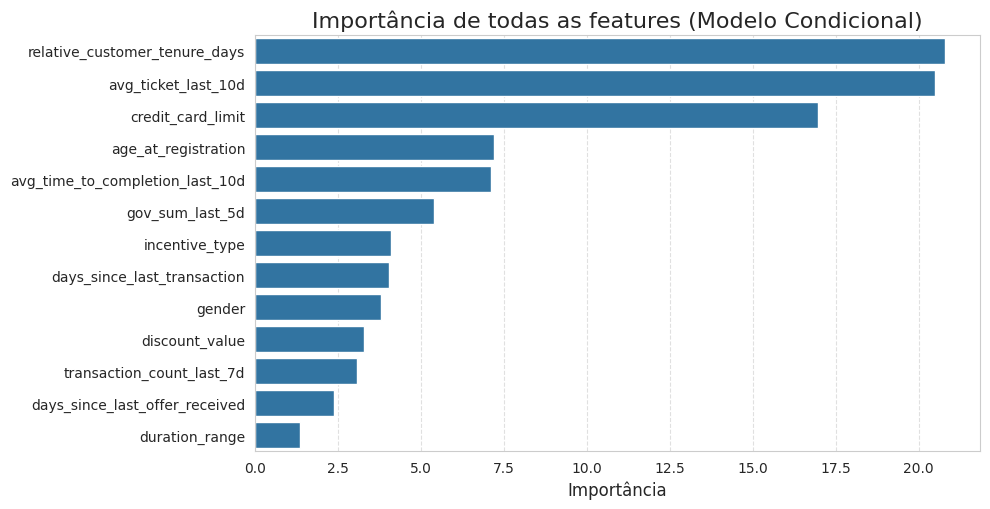

In [0]:
plot_feature_importance(model_1, 'Modelo Condicional')


As variáveis "cadastrais" se mostraram bem importantes, como: tempo de vida, limite do cartão de crédito e idade.

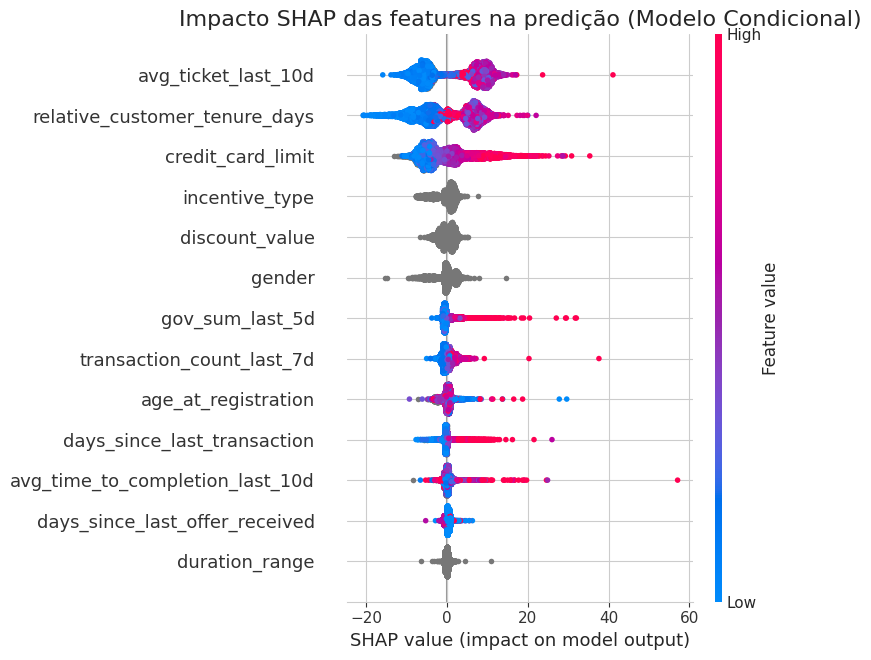

In [0]:
model_1_explainer, model_1_shap_values = calculate_shap_values(model=model_1, features_df=X_test)
plot_shap_summary_from_values(shap_values=model_1_shap_values, features_df=X_test, model_name='Modelo Condicional')


Como esperado, o ticket médio do cliente nos últimos dias se mostrou bem importante para prever o gasto futuro dele.

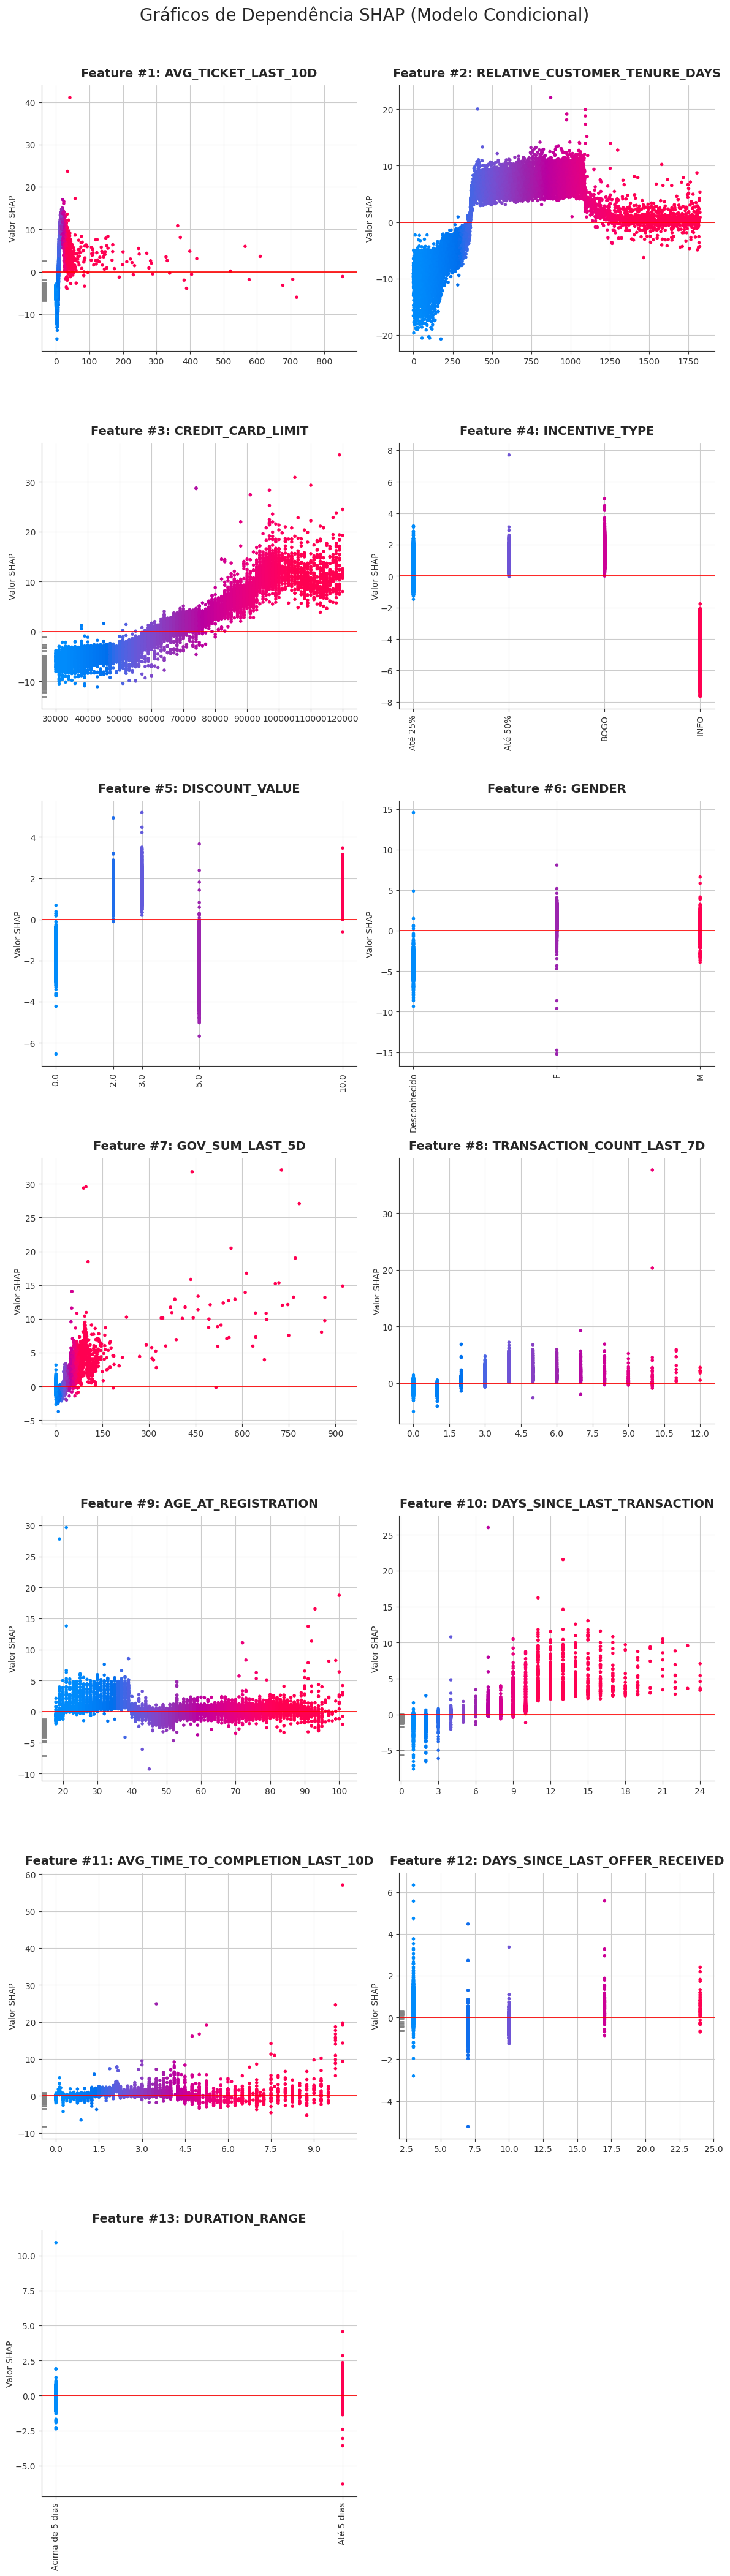

In [0]:
plot_shap_dependence_grid(
    model_1_shap_values,
    X_test,
    model_1_features,
    model_1_cat_features,
    model_name='Modelo Condicional'
)


**Principais insights obtidos:**
- Cupons do tipo *informational* apresentam baixo impacto em comparação aos demais.  
- Clientes com maior tempo sem transacionar demonstram maior sensibilidade ao recebimento de cupons.  
- Limites de cartão de crédito mais altos e maior tempo de vida aumentam o impacto do cupom.  
- Clientes mais jovens tendem a ser mais impactados ao recebimento de cupons.  

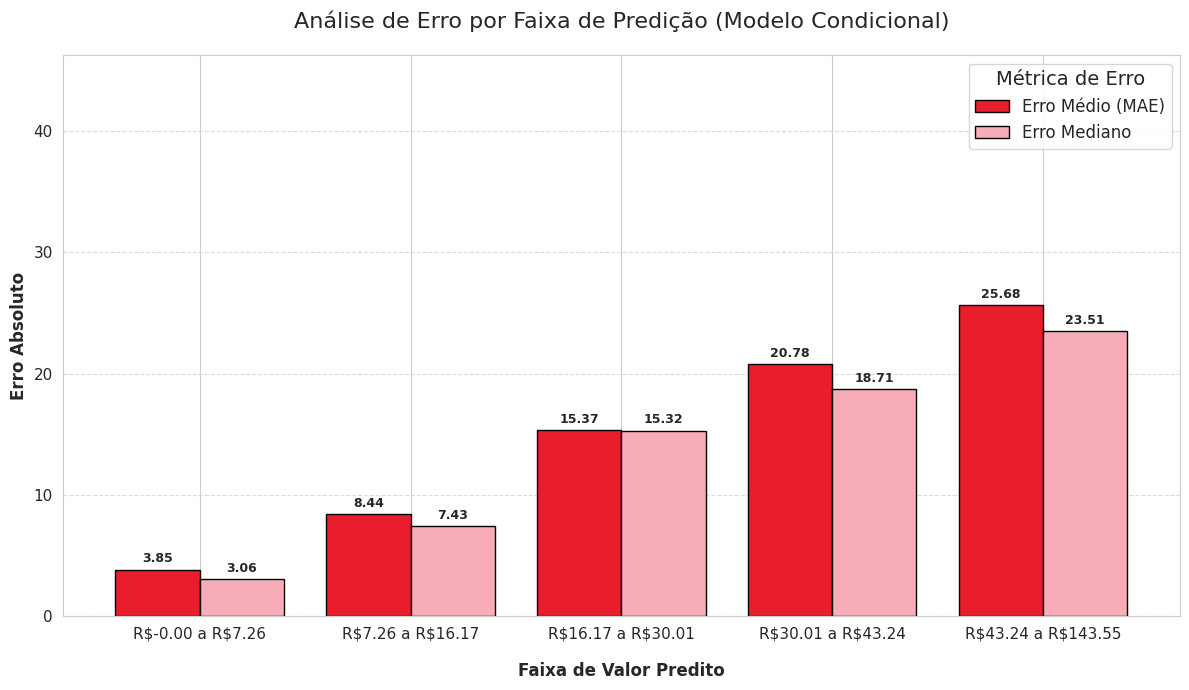

In [0]:
results_df_model_1 = plot_error_analysis_by_bin(y_test, predictions, num_bins=5, model_name='Modelo Condicional')


O erro médio está próximo ao erro mediano, porém ligeiramente maior, o que sugere a presença de outliers influenciando a distribuição.

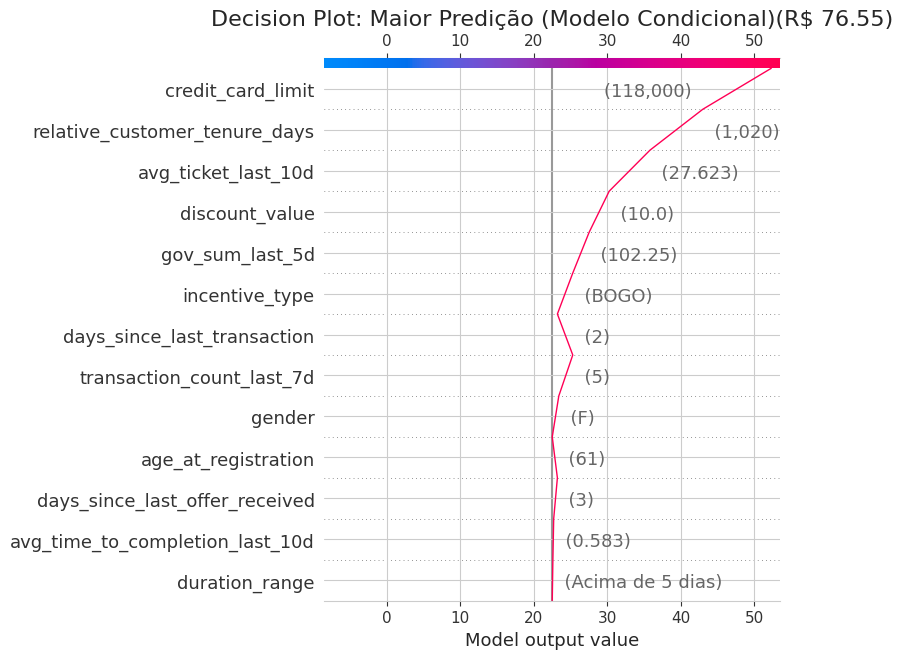

In [0]:
plot_decision_shap_for_highest_prediction(model_1_explainer, model_1_shap_values, X_test, results_df_model_1, 'Modelo Condicional')


Para o caso de maior predição, o que mais impactou no output foram as duas variáveis cadastrais mais importantes: limite do cartão de crédito e tempo de vida, além do ticket médio.

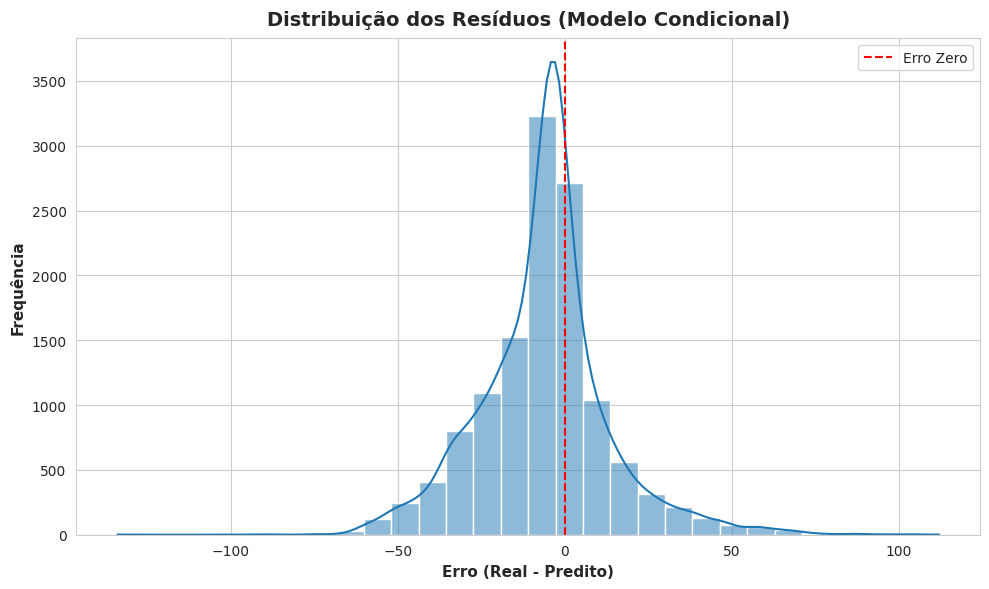

In [0]:
plot_residuals_distribution(results_df_model_1, bins=30, model_name='Modelo Condicional')


Os resíduos estão concentrados em torno de 0, porém com maior densidade à esquerda. Esse comportamento sugere a presença de outliers que levam o modelo a superestimar os valores reais.

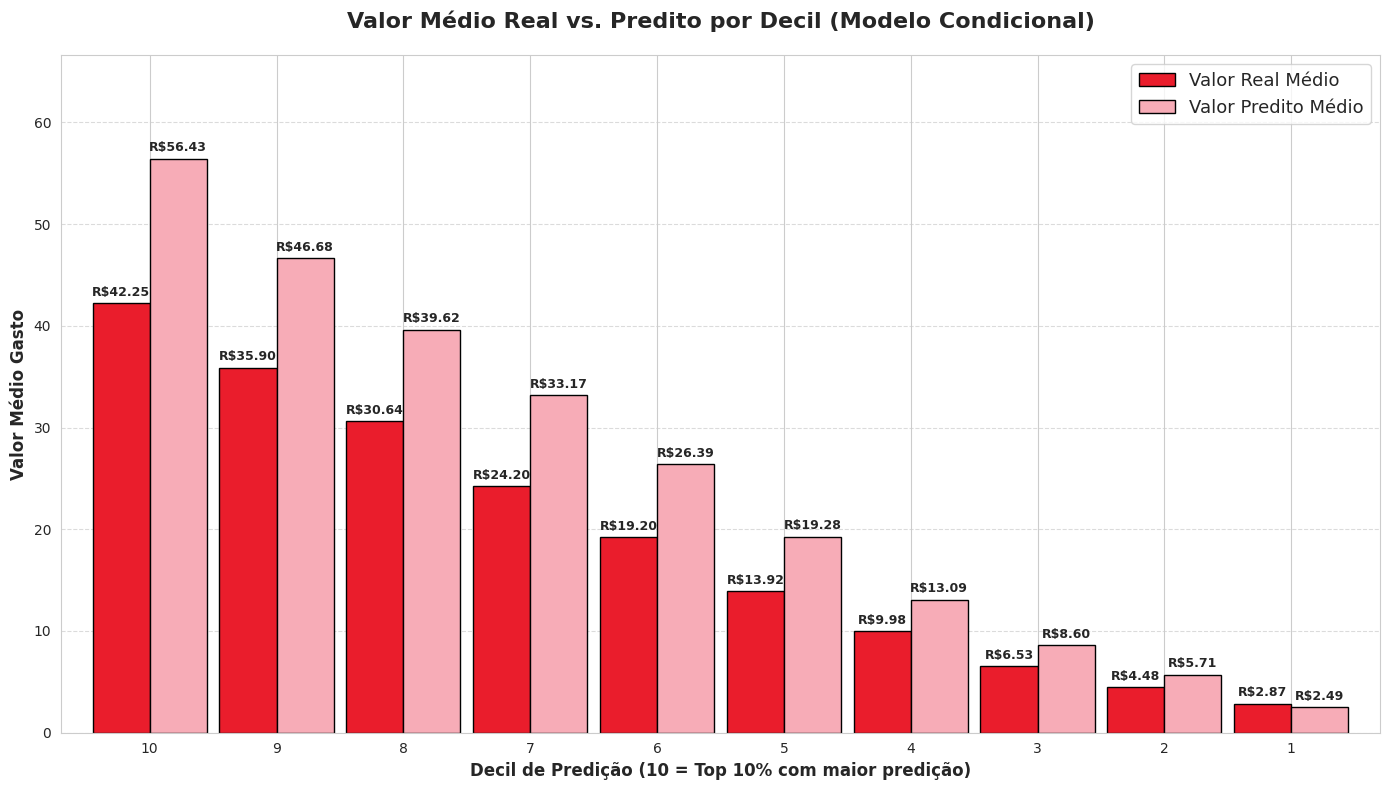

In [0]:
decile_analysis = plot_decile_analysis(y_test, predictions, model_name='Modelo Condicional')


A análise confirma a suspeita de que o modelo está superestimando os valores reais. A principal hipótese é a influência de outliers: enquanto o percentil 99 é próximo de R$100,00, observam-se valores que chegam a R$1000,00.  

Uma possível tratativa seria o tratamento desses outliers, por exemplo, aplicando *clipping* no percentil 99. No entanto, é necessário avaliar se esses pontos extremos representam ruído ou casos reais. Outras abordagens incluem:  
- Treinar modelos distintos para perfis de clientes diferentes (ex.: segmentação por ticket médio).  
- Aplicar um fator de correção para reduzir sistematicamente as previsões em X%.  

Todas essas alternativas exigem análises adicionais e ficam documentadas como potenciais melhorias futuras.  

Por outro lado, o modelo apresenta bom desempenho em ranqueamento: as barras de "Valor Real Médio" exibem um padrão de “escadinha”, evidenciando que, apesar da superestimação da magnitude, a ordenação relativa entre clientes é bem capturada.  

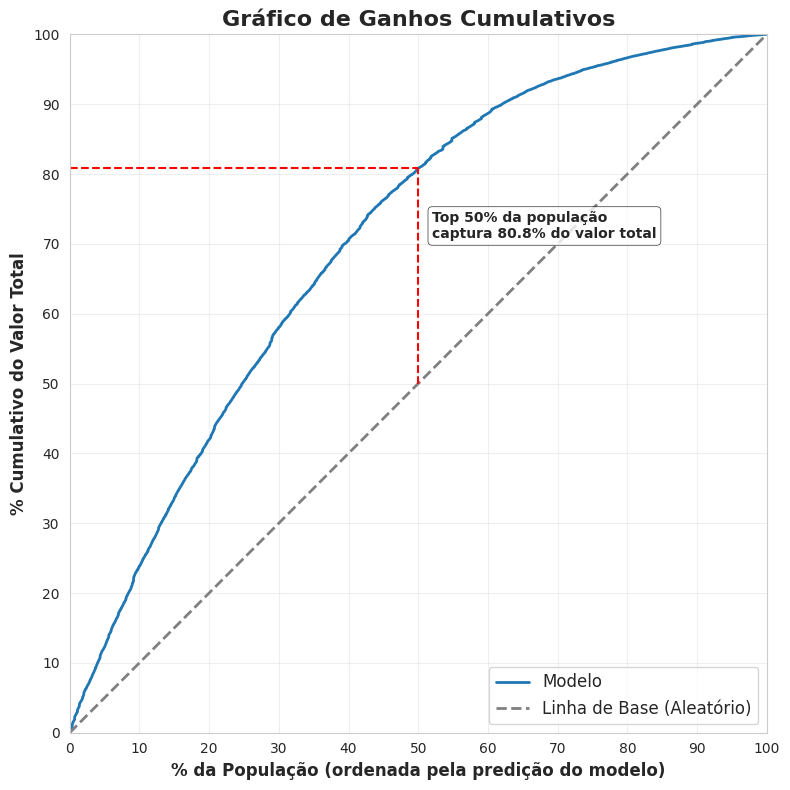

In [0]:
plot_gains_chart(y_test, predictions, highlight_percentile=50)


Outro ponto relevante é que, ao selecionar os 50% de clientes com maior predição, o modelo captura 80,8% do valor real total, mostrando que apesar da magnitude estar superestimada, ele indica forte capacidade de concentração e priorização.


## 1.4) Salvando modelo final

Aqui salvamos alguns metadados junto com o modelo propriamente dito:

- `model`: o estimador de fato
- `features_list`: features utilizadas pelo modelo (incluindo features de oferta)
- `offer_features_list`: features de oferta para facilitar
- `cat_features_list`: features categóricas
- `params`: hiperparâmetros selecionados
- `target_name`: target utilizada

In [0]:
model_1_artifacts = {
    'model': model_1,
    'features_list': model_1_features,
    'offer_features_list': OFFER_FEATURES,
    'cat_features_list': model_1_cat_features,
    'params': model_1.get_params(),
    'target_name': TARGET_NAME,
}

file_path = "modelo_condicional_artifacts.pkl"
joblib.dump(model_1_artifacts, file_path)

['modelo_condicional_artifacts.pkl']

In [0]:
# Carregar o arquivo
loaded_artifacts_1 = joblib.load(file_path)

model_1 = loaded_artifacts_1['model']
model_1_features = loaded_artifacts_1['features_list']
model_1_offer_features = loaded_artifacts_1['offer_features_list']
model_1_cat_features = loaded_artifacts_1['cat_features_list']

print(f"Modelo carregado: {type(model_1)}")
print(f"Total de features carregadas: {len(model_1_features)}")

print(f"\nLista de features: {model_1_features}")
print(f"\nLista de features de oferta: {model_1_offer_features}")
print(f"\nLista de features categoricas: {model_1_cat_features}")

Modelo carregado: <class 'catboost.core.CatBoostRegressor'>
Total de features carregadas: 13

Lista de features: ['age_at_registration', 'avg_ticket_last_10d', 'avg_time_to_completion_last_10d', 'credit_card_limit', 'days_since_last_offer_received', 'days_since_last_transaction', 'discount_value', 'duration_range', 'gender', 'gov_sum_last_5d', 'incentive_type', 'relative_customer_tenure_days', 'transaction_count_last_7d']

Lista de features de oferta: ['duration_range', 'discount_value', 'incentive_type']

Lista de features categoricas: ['discount_value', 'duration_range', 'gender', 'incentive_type']



# 2) Modelo de Gasto Orgânico
Este é o nosso segundo modelo especialista, e sua principal função é prever o comportamento de compra **natural** de um cliente, estabelecendo a linha de base (*baseline*) para nossas comparações.

## Premissas de Construção
- **Universo de Dados:** O modelo é treinado exclusivamente com dados de dias em que os clientes **não receberam nenhuma oferta**.
- **Objetivo:** O foco é aprender a relação entre o perfil histórico do cliente e o seu comportamento de compra orgânico, na ausência do estímulo de uma campanha.

## Variável Alvo (O que o modelo prevê?)
- O modelo foi treinado para prever o **valor total do gasto (`spend_next_5d`)** de um cliente durante os **próximos 5 dias**.

## Limitações e Pontos de Atenção
É importante ressaltar que a construção deste *baseline* em um ambiente não experimental possui algumas limitações.

- **Efeito de Campanhas Anteriores:** A nossa definição de "orgânico" se baseia em clientes que não receberam uma oferta *no dia da observação*. No entanto, um cliente pode ter sido impactado por uma oferta recebida no dia anterior. Uma amostragem mais complexa, que exigisse um período maior sem ofertas, seria necessária para isolar um comportamento 100% natural.

- **Ruído na Variável Alvo:** O período de 5 dias no futuro (a nossa *target*) também não é um ambiente controlado. O cliente pode, nesse intervalo, utilizar um cupom que já possuía ou ser impactado por outras campanhas, o que adiciona ruído ao que consideramos um "gasto orgânico".

- **Conclusão sobre a Abordagem:** Apesar destas limitações, a premissa do modelo é tentar capturar o impacto do nosso motor de recomendação em meio ao **ambiente natural e ruidoso do iFood**. Estamos cientes de que, para uma análise mais rigorosa, um ambiente experimental (como um Teste A/B) seria o ideal. No entanto, para o escopo deste case, o modelo atual serve como uma forte aproximação do comportamento do cliente no ecossistema real da plataforma.

In [0]:
# Dia reservado para validação final do modelo
TEST_DAY = 24

TARGET_NAME = 'spend_next_5d'

In [0]:
df_2 = pd.read_parquet(f"{PATH_VOLUME}/gold/abt_baseline")[df_cols_2]
df_2 = df_2.loc[df_2['day'] <= TEST_DAY] 

# Separa features numéricas das categóricas (importante para o catboost)
df_2_types = df_2[FEATURES + PROFILE_FEATURES].dtypes.reset_index(name='data_type')
num_cols = df_2_types.loc[df_2_types['data_type'] != 'object']['index'].tolist()
cat_cols = df_2_types.loc[df_2_types['data_type'] == 'object']['index'].tolist()


## 2.1) Pré-seleção de *features*
O mesmo processo da seção **1.1)** é realizado aqui, sem nenhuma diferença.

In [0]:
selected_num_cols = drop_correlated_features_by_performance(
    dataframe = df_2,
    feature_names = num_cols,
    target_name = TARGET_NAME,
    train_limit = 21,
    correlation_threshold = 0.8
)

Número inicial de features a considerar: 100

Features removidas por serem constantes: ['offers_received_on_day']
Número de features restantes: 99

Iniciando processo de seleção de features correlacionadas...

Features removidas por alta correlação: ['avg_ticket_last_5d', 'avg_ticket_last_7d', 'avg_time_to_completion_last_5d', 'avg_time_to_completion_last_7d', 'sum_time_to_completion_last_10d', 'bogo_transaction_count_last_10d', 'bogo_transaction_count_last_5d', 'bogo_transaction_count_last_7d', 'share_bogo_transactions_last_10d', 'share_bogo_transactions_last_7d', 'count_bogo_offers_received_last_10d', 'count_bogo_offers_received_last_7d', 'count_bogo_offers_viewed_last_5d', 'count_high_inc_offers_received_last_10d', 'count_high_inc_offers_received_last_5d', 'count_high_inc_offers_viewed_last_10d', 'count_high_inc_offers_viewed_last_7d', 'count_info_offers_received_last_10d', 'count_info_offers_viewed_last_10d', 'count_long_offers_received_last_10d', 'count_long_offers_viewed_last_10d

In [0]:
selected_cat_cols = select_categorical_features_by_mi(
    dataframe = df_2,
    categorical_features = cat_cols,
    target_name = TARGET_NAME,
    train_limit = 21,
    mi_threshold = 0.01
)

Iniciando seleção de features categóricas por Informação Mútua...

Pontuação de Informação Mútua (Top 10):
gender                                       0.097976
most_frequent_incentive_received_last_7d     0.036712
most_frequent_incentive_viewed_last_7d       0.033508
most_frequent_incentive_viewed_last_10d      0.032480
most_frequent_incentive_viewed_last_5d       0.031901
most_frequent_incentive_received_last_10d    0.031205
most_frequent_duration_viewed_last_10d       0.029526
most_frequent_duration_received_last_7d      0.028760
most_frequent_duration_viewed_last_7d        0.028582
most_frequent_incentive_received_last_5d     0.025715
Name: MI_Score, dtype: float64

Número de features categóricas inicial: 13
Número de features categóricas selecionadas: 13


In [0]:
selected_features = selected_num_cols + selected_cat_cols


## 2.2) Treinamento e Otimização do Modelo com Optuna
A principal diferença em relação ao primeiro modelo é que não foi forçada a inclusão das variáveis de oferta (por não existirem aqui). Além disso, adotamos 5 folds em vez de 3, uma vez que há mais dias sem recebimento de ofertas do que com ofertas.

In [0]:
# Reserva o ultimo dia para teste out-of-time final
df_modeling = df_2[df_2['day'] <= TEST_DAY].copy()

# Pega os dias únicos para fazer a validação cruzada
hpo_days = sorted([d for d in df_modeling['day'].unique() if d < TEST_DAY])
df_hpo = df_modeling[df_modeling['day'].isin(hpo_days)]

# Cada modelo vai treinado 5 vezes, com janelas deslizantes. Exemplo: Treino com [0, 7] e Validação com [14]
folds = [
    (hpo_days[:-5], [hpo_days[-5]]),
    (hpo_days[:-4], [hpo_days[-4]]),
    (hpo_days[:-3], [hpo_days[-3]]),
    (hpo_days[:-2], [hpo_days[-2]]),
    (hpo_days[:-1], [hpo_days[-1]])
]

In [0]:
# Roda o estudo do optuna para otimização de hiperparâmetros (seleção de features já inclusa)
study_results_2 = find_best_model_with_optuna(
    dataframe=df_hpo,
    candidate_features=selected_features,
    categorical_features=selected_cat_cols,
    target_name=TARGET_NAME,
    cv_folds=folds,
    val_day=23,
    study_name='Catboost_model_2_hpo',
    n_trials=20,
    overfitting_threshold=1.5
)

[I 2025-10-01 01:32:40,778] A new study created in memory with name: Catboost_model_2_hpo


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-01 01:33:19,837] Trial 0 finished with value: 16.493842722287546 and parameters: {'n_features': 10, 'iterations': 1059, 'learning_rate': 0.06609945340997164, 'depth': 4, 'l2_leaf_reg': 5.979932355532655, 'colsample_bylevel': 0.5156829627888853}. Best is trial 0 with value: 16.493842722287546.
[I 2025-10-01 01:34:10,912] Trial 1 finished with value: 16.87293683292676 and parameters: {'n_features': 5, 'iterations': 995, 'learning_rate': 0.0027381976016010064, 'depth': 8, 'l2_leaf_reg': 2.392378528414762, 'colsample_bylevel': 0.799147719925213}. Best is trial 0 with value: 16.493842722287546.
[I 2025-10-01 01:36:06,587] Trial 2 finished with value: 16.567247314877076 and parameters: {'n_features': 25, 'iterations': 869, 'learning_rate': 0.00412825888382773, 'depth': 7, 'l2_leaf_reg': 4.080863801339928, 'colsample_bylevel': 0.9863927530248422}. Best is trial 0 with value: 16.493842722287546.
[I 2025-10-01 01:36:48,716] Trial 3 finished with value: 16.673411728468025 and paramete

In [0]:
# Treino do modelo final (retorna também o conjunto de teste)
model_2, X_test_2, y_test_2, predictions_2 = train_and_evaluate_final_model(
    study = study_results_2,
    dataframe = df_2,
    target_name = TARGET_NAME,
    test_day = TEST_DAY,
    day_column_name = 'day'
)

Trial vencedor: #13
Número de features selecionadas: 20

Métricas Finais no Conjunto de Teste
  holdout_test_mae: 19.6816
  holdout_test_rmse: 63.3364
  holdout_test_median_ae: 9.7366



Um ponto de atenção é que o recebimento de ofertas ocorre em datas específicas, como o dia 24. Nesse caso, o volume de observações é consideravelmente menor em relação aos demais dias, o que pode aumentar a instabilidade da métrica. Ainda assim, manteremos essa configuração.


## 2.3) Avaliação do Modelo Finalista
Nesta etapa, não há diferenças em relação às análises realizadas no modelo anterior.

In [0]:
model_2_features = study_results_2.best_trial.user_attrs['selected_features_list']
model_2_cat_features = study_results_2.best_trial.user_attrs['selected_cat_cols_list']

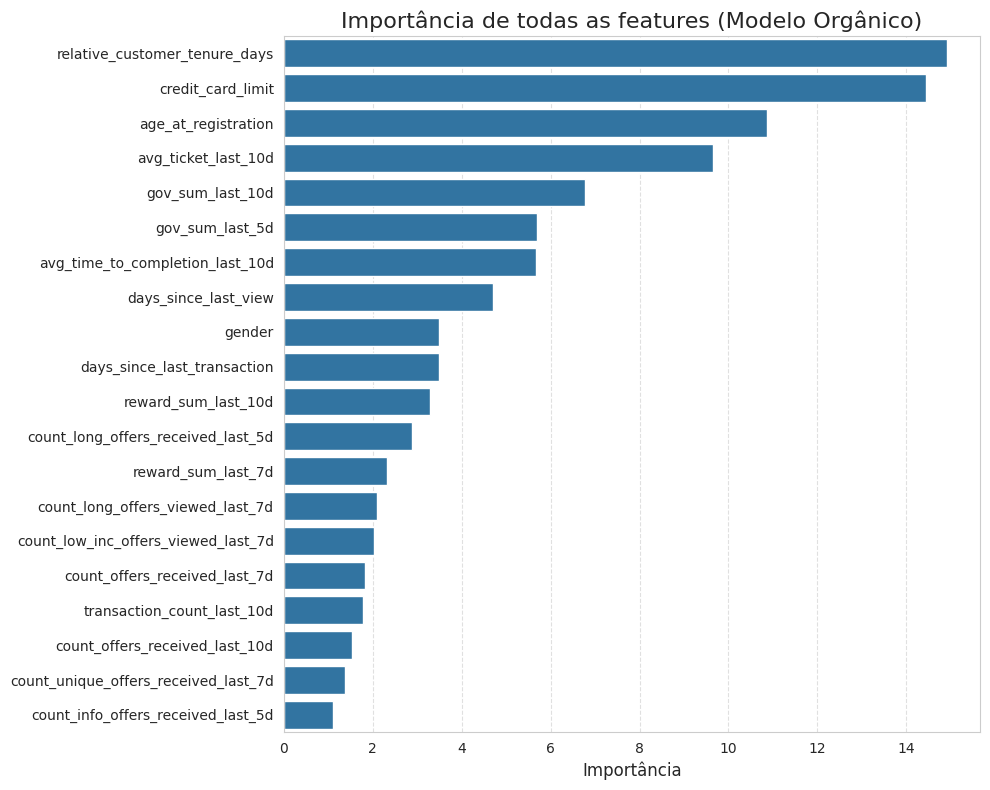

In [0]:
plot_feature_importance(model_2, 'Modelo Orgânico')


As variáveis cadastrais continuam apresentando relevância neste modelo. Observa-se, porém, a predominância de variáveis relacionadas ao recebimento de cupons nos dias anteriores, reforçando o ponto levantado sobre clientes que, em um dia específico, não recebem cupom, mas foram impactados por cupons recebidos nos dias anteriores.

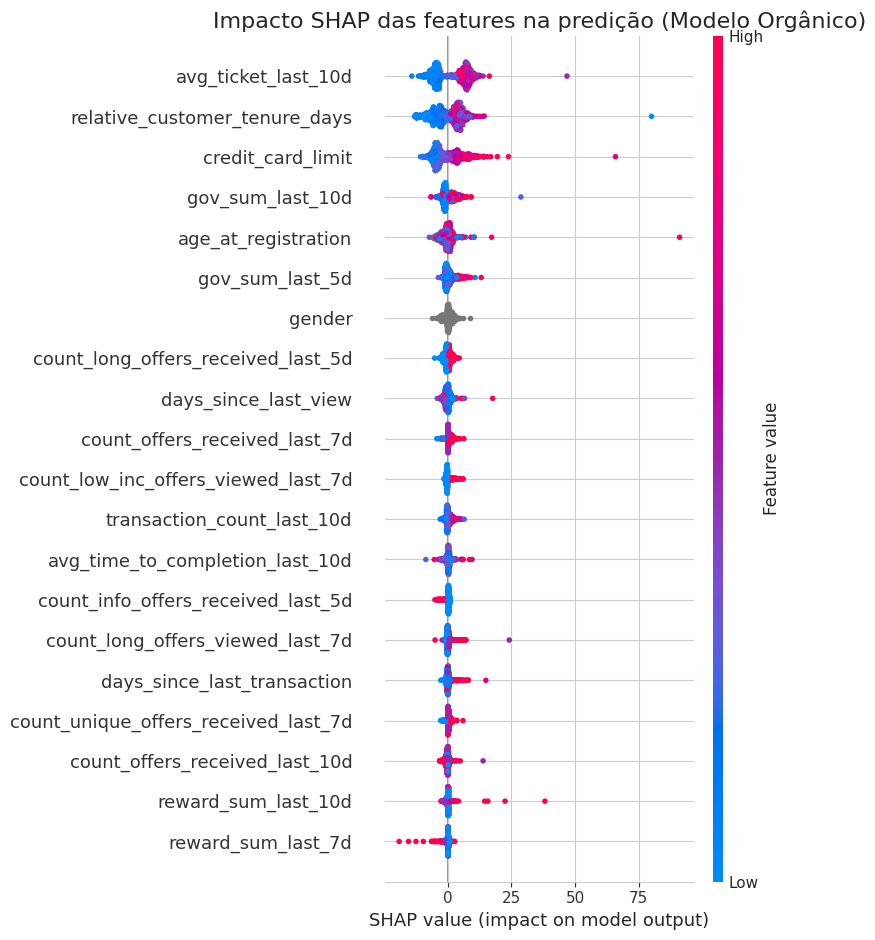

In [0]:
model_2_explainer, model_2_shap_values = calculate_shap_values(model=model_2, features_df=X_test_2)
plot_shap_summary_from_values(shap_values=model_2_shap_values, features_df=X_test_2, model_name='Modelo Orgânico')


As três variáveis mais importantes mantêm-se iguais às identificadas no modelo condicional.

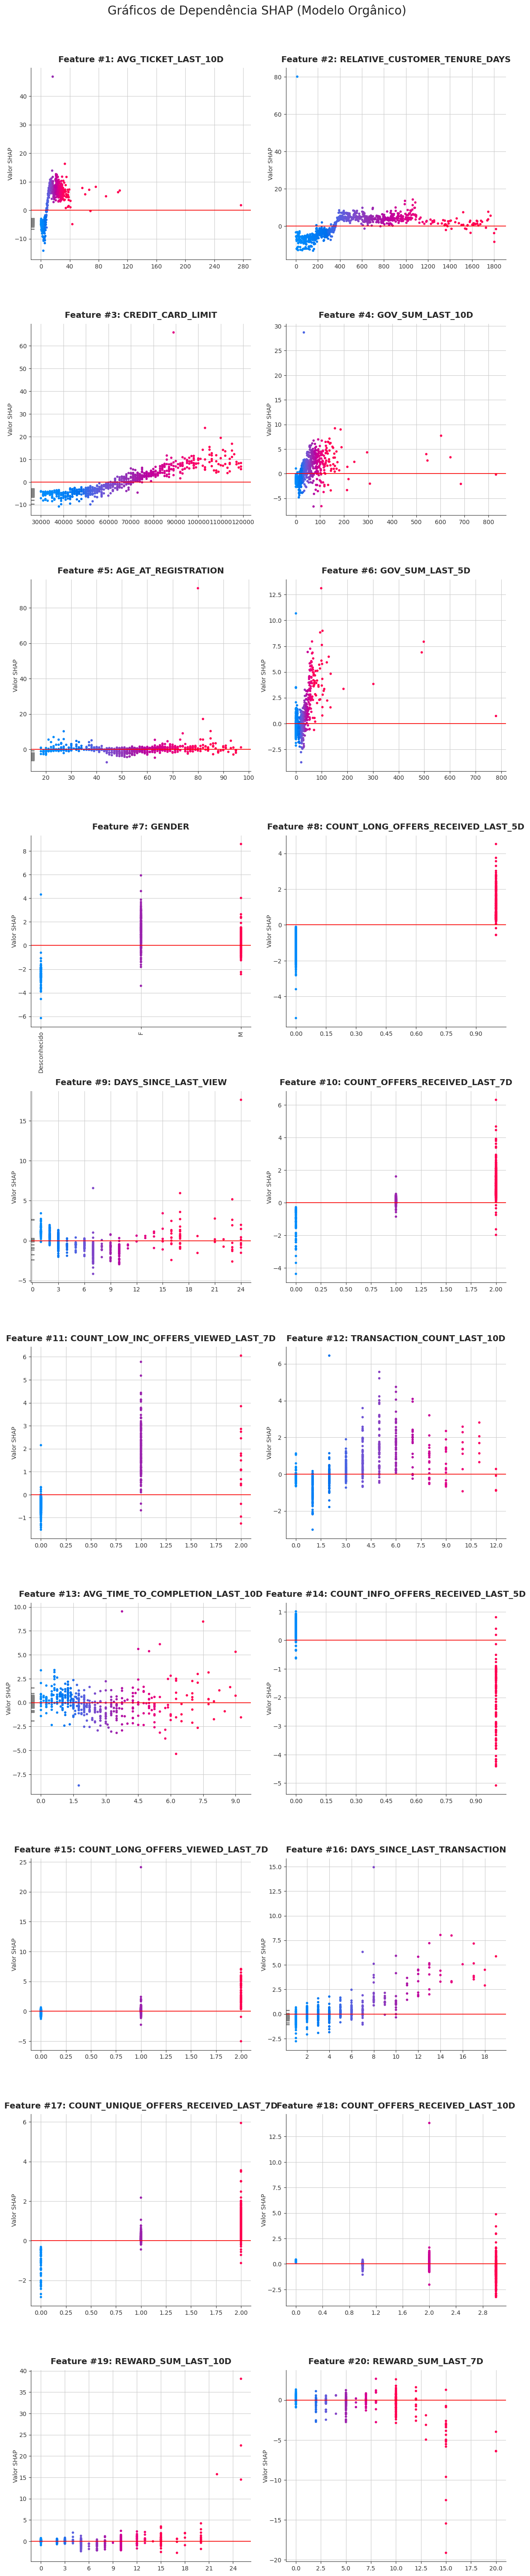

In [0]:
plot_shap_dependence_grid(
    model_2_shap_values,
    X_test_2,
    model_2_features,
    model_2_cat_features,
    model_name='Modelo Orgânico'
)


**Principais insights obtidos:**
- O recebimento de *long offers* nos dias recentes influencia positivamente a previsão.  
- A visualização de ofertas recentes também aumenta a previsão.  
- Clientes mais ativos apresentam tendência a maiores previsões (faz sentido).  
- Receber mais de uma oferta na última semana tem efeito positivo na previsão.

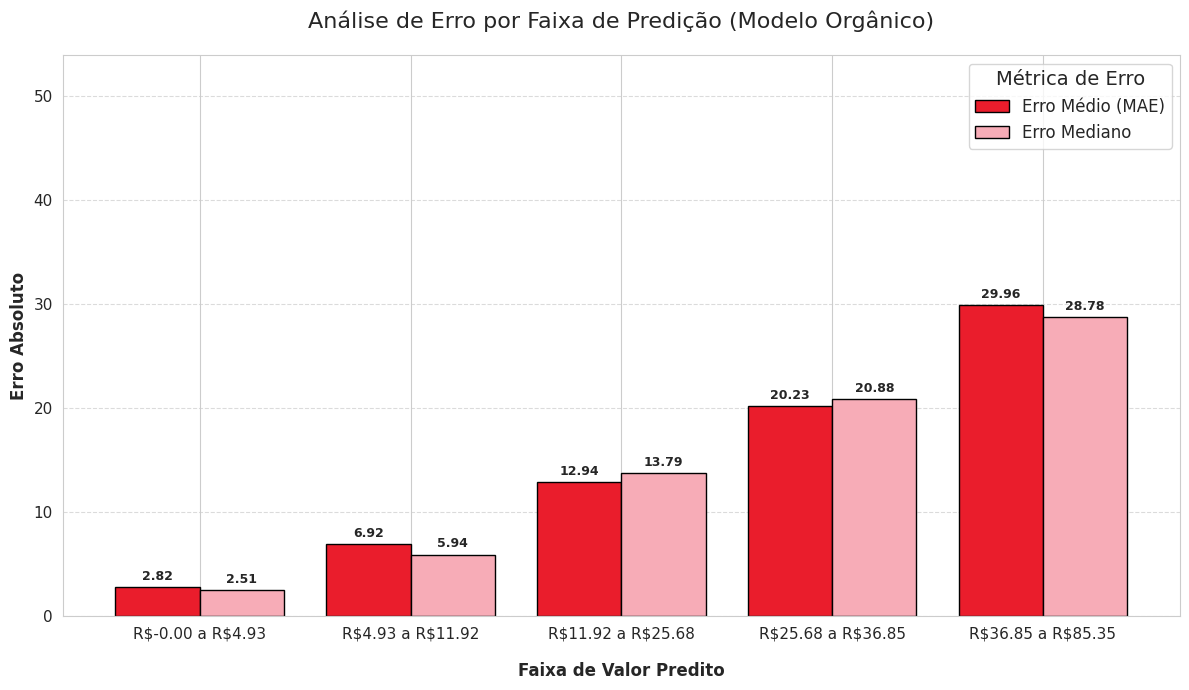

In [0]:
results_df_model_2 = plot_error_analysis_by_bin(y_test_2, predictions_2, num_bins=5, model_name='Modelo Orgânico')


A comparação aqui se assemelha muito ao modelo condicional, porém a diferença entre o erro médio e mediano está menor.

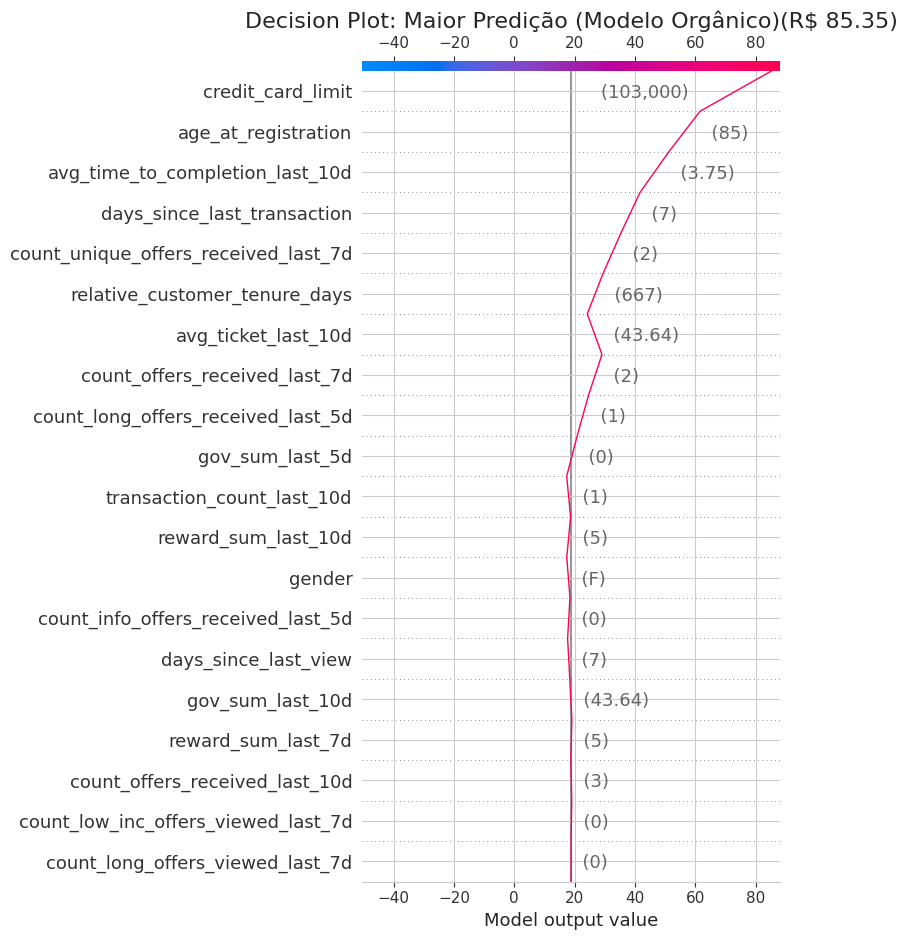

In [0]:
plot_decision_shap_for_highest_prediction(model_2_explainer, model_2_shap_values, X_test_2, results_df_model_2, 'Modelo Orgânico')


O cliente com maior previsão apresenta os seguintes atributos:  
- Tempo médio de 3,75 dias entre o recebimento e o uso do cupom.  
- Ausência de transações nos últimos 7 dias.  
- Recebimento de 2 ofertas diferentes nos últimos 7 dias.  
- Ticket médio, idade e limite de cartão de crédito elevados.  

Essa observação reforça a necessidade de uma abordagem mais cuidadosa na amostragem do modelo orgânico, já que indica que esses clientes podem estar sendo influenciados por cupons recebidos anteriormente.

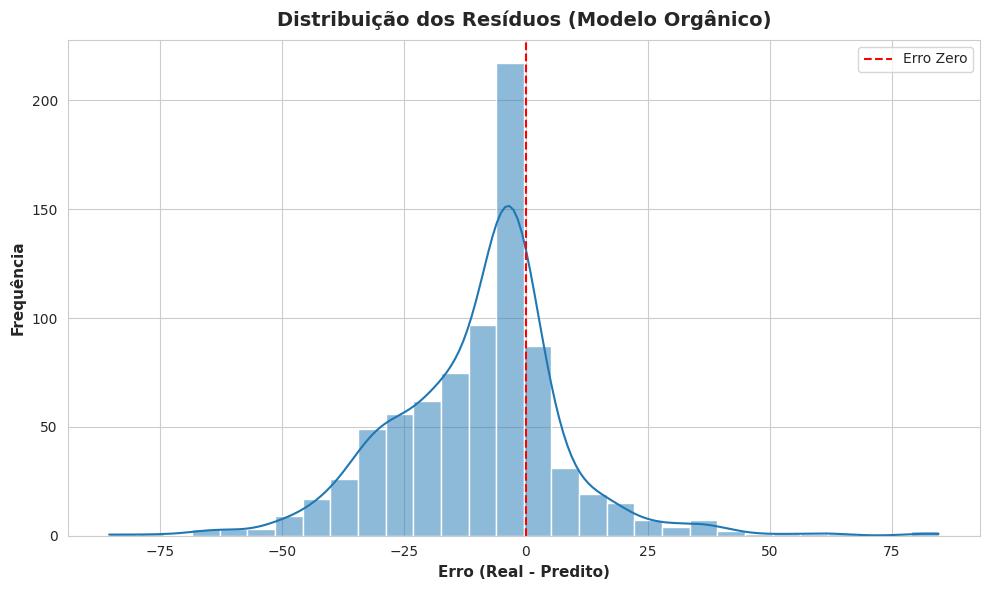

In [0]:
plot_residuals_distribution(results_df_model_2, bins=30, model_name='Modelo Orgânico')


Na distribuição dos resíduos, observa-se que o modelo orgânico também tende a superestimar os valores reais, explicando a maior concentração à esquerda.

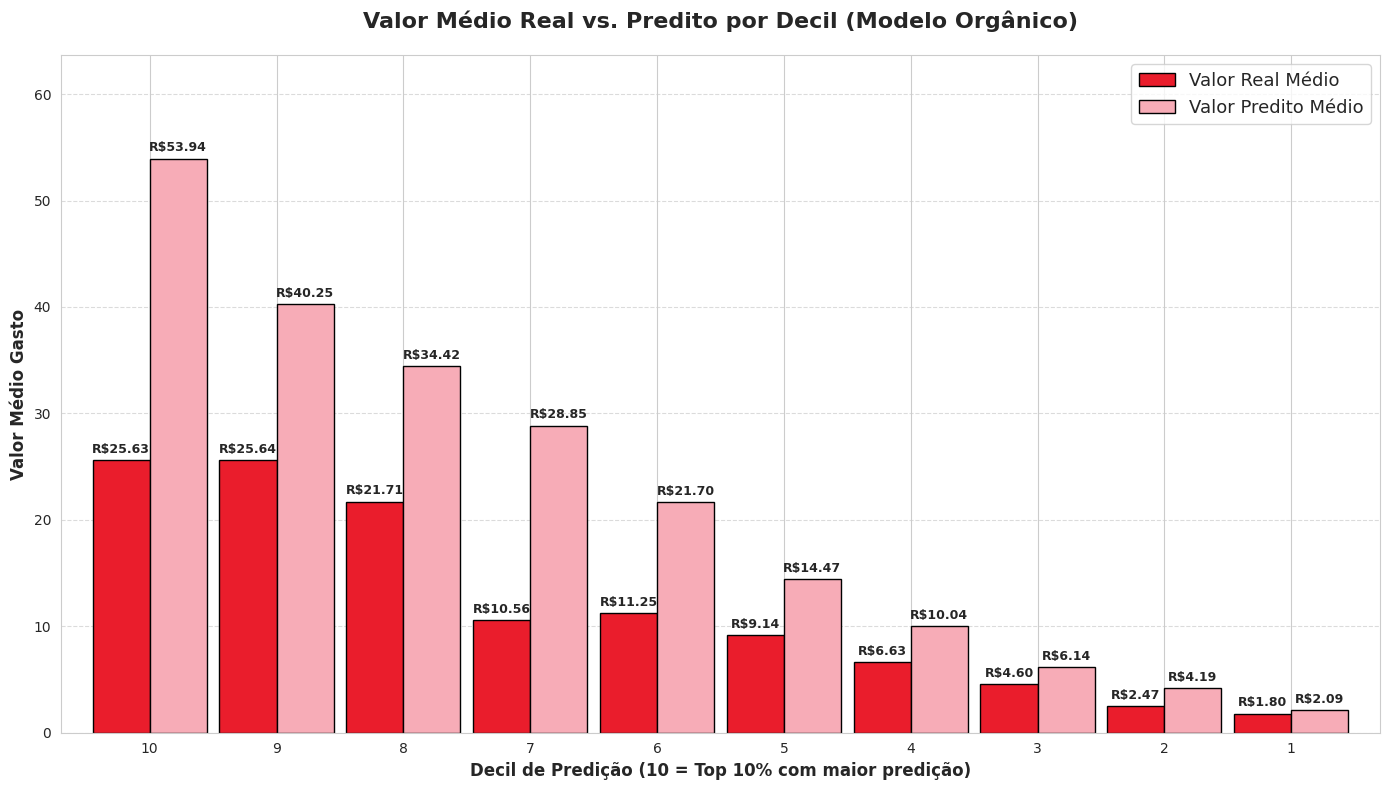

In [0]:
decile_analysis = plot_decile_analysis(y_test_2, predictions_2, model_name='Modelo Orgânico')


A performance deste modelo não atingiu o nível do modelo condicional, embora haja alguma ordenação entre os decisores. Observa-se, novamente, que as predições estão significativamente superestimadas, sugerindo a presença de outliers.  

Vale destacar que o dia de teste utilizado apresentou recebimento massivo de ofertas, com volume menor de observações, o que aumenta a volatilidade das métricas.  

A seguir, será apresentado o gráfico referente ao dia 23 (último dia da validação) para análise do erro.

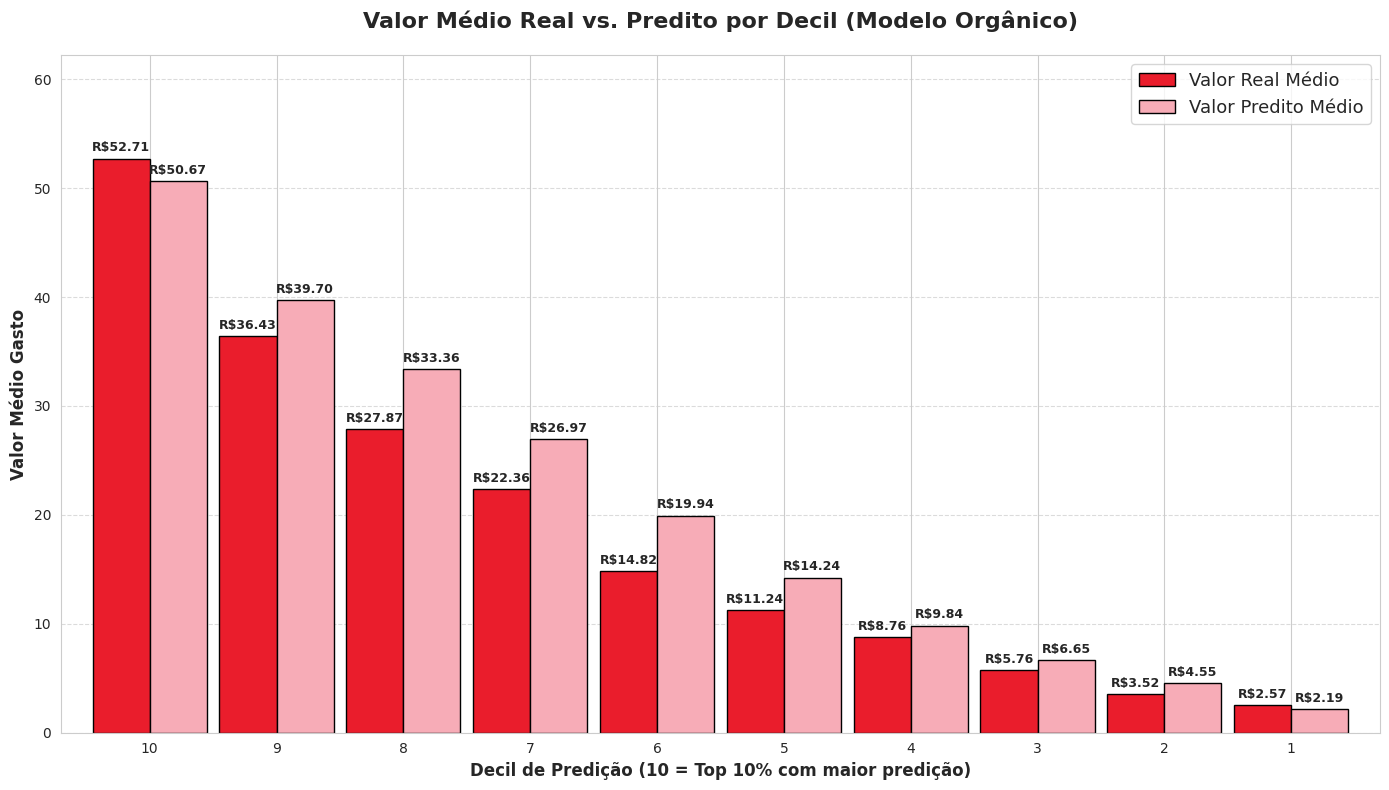

,avg_actual,avg_predicted
decile,,
10,52.707092,50.673555
9,36.430268,39.695818
8,27.867537,33.356861
7,22.362560,26.974242
6,14.816339,19.936076
5,11.244303,14.236298
4,8.755923,9.840969
3,5.756469,6.653817
2,3.515982,4.551759


In [0]:
plot_decile_analysis(df_2.loc[df_2['day'] == 23]['spend_next_5d'], model_2.predict(df_2.loc[df_2['day'] == 23][model_2_features]), model_name='Modelo Orgânico')


Como melhoria, sugere-se considerar a exclusão dos dias com recebimento massivo de ofertas. Além disso, muitos clientes que não receberam cupom no dia 24 podem ter recebido no dia 21, o que pode comprometer a consistência do conjunto de teste.


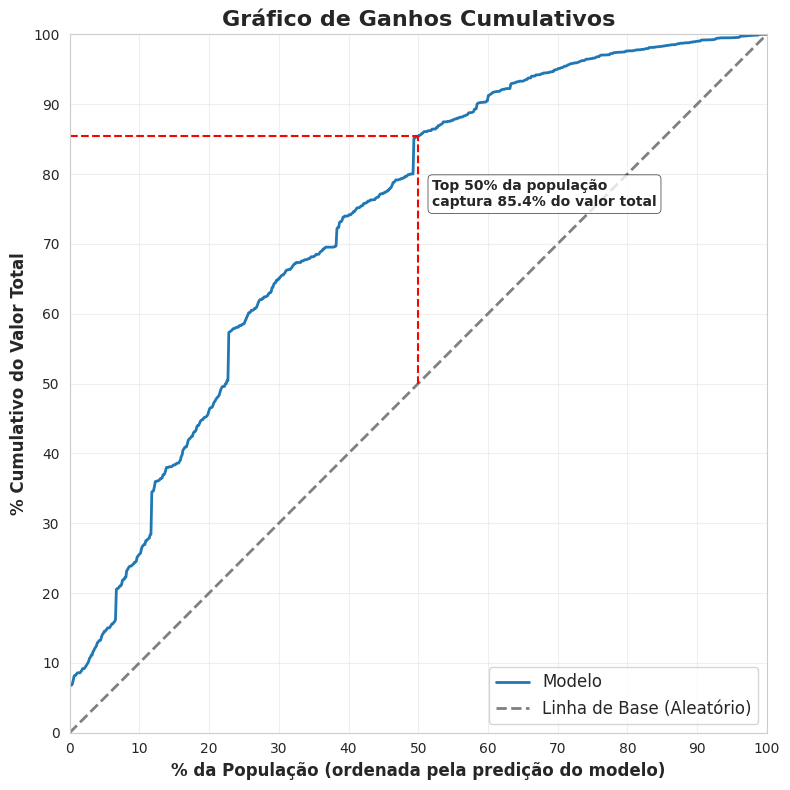

In [0]:
plot_gains_chart(y_test_2, predictions_2, highlight_percentile=50)


Apesar das métricas não atingirem os valores esperados, o modelo consegue ranquear adequadamente os clientes com maior volume de gasto. Ao selecionar os 50% de clientes com maior predição, aproximadamente 85,4% do valor total gasto nos próximos 5 dias é capturado.


## 2.4) Salvando modelo final

Aqui salvamos alguns metadados junto com o modelo propriamente dito:

- `model`: o estimador de fato
- `features_list`: features utilizadas pelo modelo (não há features de oferta)
- `cat_features_list`: features categóricas
- `params`: hiperparâmetros selecionados
- `target_name`: target utilizada

In [0]:
model_2_artifacts = {
    'model': model_2,
    'features_list': model_2_features,
    'cat_features_list': model_2_cat_features,
    'params': model_2.get_params(),
    'target_name': TARGET_NAME,
}

file_path = "modelo_organico_artifacts.pkl"
joblib.dump(model_2_artifacts, file_path)

['modelo_organico_artifacts.pkl']

In [0]:
# Carregar o arquivo
loaded_artifacts_2 = joblib.load(file_path)

model_2 = loaded_artifacts_2['model']
model_2_features = loaded_artifacts_2['features_list']
model_2_cat_features = loaded_artifacts_2['cat_features_list']

print(f"Modelo carregado: {type(model_2)}")
print(f"Total de features carregadas: {len(model_2_features)}")

print(f"\nLista de features: {model_2_features}")
print(f"\nLista de features categoricas: {model_2_cat_features}")

Modelo carregado: <class 'catboost.core.CatBoostRegressor'>
Total de features carregadas: 20

Lista de features: ['age_at_registration', 'avg_ticket_last_10d', 'avg_time_to_completion_last_10d', 'count_info_offers_received_last_5d', 'count_long_offers_received_last_5d', 'count_long_offers_viewed_last_7d', 'count_low_inc_offers_viewed_last_7d', 'count_offers_received_last_10d', 'count_offers_received_last_7d', 'count_unique_offers_received_last_7d', 'credit_card_limit', 'days_since_last_transaction', 'days_since_last_view', 'gender', 'gov_sum_last_10d', 'gov_sum_last_5d', 'relative_customer_tenure_days', 'reward_sum_last_10d', 'reward_sum_last_7d', 'transaction_count_last_10d']

Lista de features categoricas: ['gender']



# 3) Resultados e Estimativas

Nesta seção, aplicaremos os modelos treinados para estimar o retorno de uma campanha, considerando o período de 5 dias. O objetivo é avaliar se, mesmo assumindo o custo do cupom, vale a pena para o restaurante impulsionar campanhas utilizando nosso modelo.

Uma abordagem alternativa de validação seria considerar as taxas cobradas pelo iFood (12% para o plano básico e 23% para o plano de entrega). No entanto, como não dispomos da proporção de clientes em cada plano, não é possível estimar a comissão do iFood ao final da campanha. Ainda assim, com os dados de receita bruta e líquida dos restaurantes, esse cálculo seria simples de implementar.

Devido à superestimação dos valores reais pelos nossos modelos, optamos por focar em resultados percentuais em vez de valores absolutos (R$), o que ajuda a mitigar esse viés, uma vez que ambos os modelos apresentam esse comportamento.

In [0]:
model_1_file_path = "modelo_condicional_artifacts.pkl"
model_2_file_path = "modelo_organico_artifacts.pkl"

loaded_artifacts_1 = joblib.load(model_1_file_path)
loaded_artifacts_2 = joblib.load(model_2_file_path)

all_model_features = list(set(loaded_artifacts_1['features_list'] + loaded_artifacts_2['features_list']) - set(OFFER_FEATURES))


## 3.1) Construindo tabela de simulação 
Aqui nós construímos a tabela que contém todos os cenários possíveis: todos os tipos de ofertas (incluindo não receber oferta). É com base nesta tabela que iremos calcular o lift das estratégias.

In [0]:
# Pegando última data disponível da feature store
feature_store = (
    spark
    .read
    .parquet(f"{PATH_VOLUME}/gold/customer_daily_features")
    .filter(F.col('day') == 29)
    .select(*ID_FEATURES + all_model_features)
    .toPandas()
)

# Tabela com as características únicas de ofertas
offers = (
    spark
    .read
    .parquet(f"{PATH_VOLUME}/silver/offers")
    .select('duration_range', 'incentive_type', 'discount_value')
    .distinct()
    .toPandas()
)
offers[OFFER_FEATURES] = offers[OFFER_FEATURES].astype('str')

# Para cada cliente, geramos uma linha para cada oferta
simulation_table = feature_store.merge(offers, how='cross')
simulation_table['offer_cost'] = simulation_table['discount_value'].astype('float')

# Para todos os cenários onde enviamos cupom, utilizamos o Modelo Condicional
simulation_1 = simulation_table.copy()
simulation_1['spend_next_5d'] = loaded_artifacts_1['model'].predict(simulation_1[loaded_artifacts_1['features_list']])
simulation_1 = simulation_1.drop(columns=all_model_features + ['discount_value'])

# Para o cenário onde não enviamos cupom, utilizados o Modelo Orgânico
simulation_2 = simulation_table.drop(columns=OFFER_FEATURES+['discount_value', 'offer_cost']).drop_duplicates()
simulation_2['offer_cost'] = 0
simulation_2['spend_next_5d'] = loaded_artifacts_2['model'].predict(simulation_2[loaded_artifacts_2['features_list']])
simulation_2 = simulation_2.drop(columns=all_model_features)

# Resultados das simulações para cada cenário
simulation_results = pd.concat([simulation_1, simulation_2]).fillna('NA')

# Incluindo a coluna do baseline para facilitar os cálculos
simulation_results = simulation_results.merge(
    simulation_2.rename(columns={'spend_next_5d': 'spend_next_5d_baseline'}).drop(columns='offer_cost'),
    on=['account_id', 'day'],
    how='left'
)


## 3.2) Vale a pena o restaurante impulsionar campanhas?
Nesta seção, avaliaremos se, ao assumir o custo do cupom, o restaurante ainda obtém ROI positivo. Para isso, consideraremos que o restaurante possui um orçamento definido para campanhas de cupons e precisa selecionar os clientes e cupons mais adequados.

Serão comparadas duas estratégias:

### Estratégia Atual
O restaurante envia seu cupom mais lucrativo para os clientes mais ativos, como forma de recompensa.

### Campanha Inteligente (Proposta Sugerida)
Nosso modelo de ML identifica os clientes com maior *lift* incremental, priorizando-os no envio de cupons. Dessa forma, evitamos enviar cupons para clientes que não gerarão aumento no volume de compras, focando apenas naqueles cujo comportamento será impactado.

In [0]:
retorno_total_sem_cupom = simulation_2['spend_next_5d'].sum().round(2)
print(f'Retorno total esperado se não mandarmos cupom para nenhum cliente: R${retorno_total_sem_cupom:,}')

Retorno total esperado se não mandarmos cupom para nenhum cliente: R$343,401.32


In [0]:
restaurant_scenario = simulation_results.copy()

# Retorno liquido para o restaurante, dado que ele custeia o cupom
restaurant_scenario['net_spend_next_5d'] = restaurant_scenario['spend_next_5d'] - restaurant_scenario['offer_cost']

# Lift em R$ (o ganho que enviar o cupom traz ao restaurante)
restaurant_scenario['net_lift_reais'] = restaurant_scenario['net_spend_next_5d'] - restaurant_scenario['spend_next_5d_baseline']

# Encontra a melhor oferta para cada cliente
idx_maior_lift = restaurant_scenario.groupby('account_id')['net_lift_reais'].idxmax()
melhores_ofertas_por_cliente = restaurant_scenario.loc[idx_maior_lift]

# Defina o orçamento da campanha
BUDGET = 5000

# Ordena os clientes pela melhor oportunidade (maior lift primeiro).
clientes_priorizados = melhores_ofertas_por_cliente.sort_values('net_lift_reais', ascending=False)

# Calcula o custo acumulado de enviar a oferta para cada cliente na ordem de prioridade.
clientes_priorizados['custo_acumulado'] = clientes_priorizados['offer_cost'].cumsum()

# Filtra para selecionar apenas os clientes que se encaixam no orçamento.
campanha_final_otimizada = clientes_priorizados[clientes_priorizados['custo_acumulado'] <= BUDGET].copy()

# Resumo da Campanha Final
print(f"Campanha Inteligente com Orçamento de R${BUDGET:,}")
print(f"Número de clientes a serem impactados: {len(campanha_final_otimizada):,}")
print(f"\nReceita total esperada sem a campanha: R${campanha_final_otimizada['spend_next_5d_baseline'].sum():,.2f}")
print(f"Receita total esperada com a campanha: R${campanha_final_otimizada['net_spend_next_5d'].sum():,.2f}")
print(f"\nCusto total da campanha: R${campanha_final_otimizada['offer_cost'].sum():,.2f}")
print(f"\nLucro incremental esperado (Lift Líquido): R$ {campanha_final_otimizada['net_lift_reais'].sum():,.2f}")
print(f"A campanha traz um aumento de receita de {campanha_final_otimizada['net_lift_reais'].sum()/campanha_final_otimizada['spend_next_5d_baseline'].sum():,.2%} em comparação ao cenário sem campanha.")

# Calcula o ROI final da campanha otimizada
roi_otimizado = (
    campanha_final_otimizada['net_lift_reais'].sum() / 
    campanha_final_otimizada['offer_cost'].sum()
)
print(f"\nROI esperado (Lucro / Custo): {roi_otimizado:.2%}")

Campanha Inteligente com Orçamento de R$5,000
Número de clientes a serem impactados: 2,080

Receita total esperada sem a campanha: R$56,755.74
Receita total esperada com a campanha: R$106,226.25

Custo total da campanha: R$4,998.00

Lucro incremental esperado (Lift Líquido): R$ 49,470.51
A campanha traz um aumento de receita de 87.16% em comparação ao cenário sem campanha.

ROI esperado (Lucro / Custo): 989.81%


In [0]:
# Definição dos critérios da campanha
BUDGET = 5000
HEURISTIC_OFFER_CRITERIA = {
    'duration_range': 'Acima de 5 dias',
    'offer_cost': 2,
    'incentive_type': 'Até 25%'
}
ACTIVITY_COLUMN = 'transaction_count_last_10d'

# Filtra a tabela de simulação para conter apenas a oferta específica da heurística
heuristic_df = simulation_results.copy()
heuristic_df['net_spend_next_5d'] = heuristic_df['spend_next_5d'] - heuristic_df['offer_cost']
heuristic_df['net_lift_reais'] = heuristic_df['net_spend_next_5d'] - heuristic_df['spend_next_5d_baseline']
heuristic_df = heuristic_df.merge(simulation_table[['account_id', ACTIVITY_COLUMN]].drop_duplicates(), on='account_id', how='left')
for column, value in HEURISTIC_OFFER_CRITERIA.items():
    heuristic_df = heuristic_df[heuristic_df[column] == value]

# 2. Ordena os clientes pela coluna de atividade (os mais ativos primeiro)
clientes_priorizados = heuristic_df.sort_values(ACTIVITY_COLUMN, ascending=False)

# 3. Calcula o custo acumulado para aplicar o orçamento
clientes_priorizados['custo_acumulado'] = clientes_priorizados['offer_cost'].cumsum()

# 4. Filtra para selecionar apenas os clientes que se encaixam no orçamento
campanha_final_heuristica = clientes_priorizados[clientes_priorizados['custo_acumulado'] <= BUDGET].copy()

# --- Resumo da Campanha Heurística ---
print(f"Campanha Heurística com Orçamento de R${BUDGET:,}")

if not campanha_final_heuristica.empty:
    # Extrai os valores para o resumo
    custo_total = campanha_final_heuristica['offer_cost'].sum()
    lucro_total = campanha_final_heuristica['net_lift_reais'].sum()
    baseline_total = campanha_final_heuristica['spend_next_5d_baseline'].sum()
    
    # Evita divisão por zero
    aumento_receita = (lucro_total / baseline_total) if baseline_total > 0 else 0
    roi = (lucro_total / custo_total) if custo_total > 0 else 0
    
    print(f"Número de clientes a serem impactados: {len(campanha_final_heuristica):,}")

    print(f"\nReceita total esperada sem a campanha: R$ {baseline_total:,.2f}")
    print(f"Receita total esperada com a campanha: R${campanha_final_heuristica['net_spend_next_5d'].sum():,.2f}")

    print(f"\nCusto total da campanha: R$ {custo_total:,.2f}")
    print(f"\nLucro incremental esperado (Lift Líquido): R$ {lucro_total:,.2f}")
    print(f"A campanha traz um aumento de receita de {aumento_receita:,.2%} em comparação ao cenário sem campanha.")
    print(f"ROI esperado (Lucro / Custo): {roi:.2%}")
else:
    print("Nenhum cliente selecionado para a campanha com os critérios e orçamento definidos.")

Campanha Heurística com Orçamento de R$5,000
Número de clientes a serem impactados: 2,500

Receita total esperada sem a campanha: R$ 58,614.74
Receita total esperada com a campanha: R$72,727.08

Custo total da campanha: R$ 5,000.00

Lucro incremental esperado (Lift Líquido): R$ 14,112.34
A campanha traz um aumento de receita de 24.08% em comparação ao cenário sem campanha.
ROI esperado (Lucro / Custo): 282.25%


In [0]:
lift_inteligente = 49470.51
lift_heuristica = 14112.34

comissao_ifood_inteligente = 
print(f"O ROI da estratégia inteligente é de {lift_inteligente/lift_heuristica:.1f}x maior que a estratégia heurística.")

O ROI da estratégia inteligente é de 3.5x maior que a estratégia heurística.



# 4) Discussão sobre Limitações e Melhorias Futuras

## 4.1) Quantificação de Incerteza
Uma limitação não abordada no case é a **quantificação da incerteza das predições**. Embora conheçamos o erro médio e mediano, não temos indicação de quais predições são mais ou menos confiáveis. Uma possível abordagem para lidar com isso é o uso de *Conformal Prediction*, que fornece intervalos de predição com garantias estatísticas para um nível de confiança definido. A biblioteca `crepes` oferece suporte a métodos atuais nesse sentido.

## 4.2) Amostragem do grupo orgânico
A amostragem do grupo que não recebe cupom apresenta algumas limitações, sendo uma delas a dificuldade de medir o impacto do cupom enviado devido à presença de cupons paralelos. Embora não seja um problema trivial de resolver, uma melhoria inicial seria aplicar filtros adicionais para excluir clientes que receberam cupons muito recentemente, reduzindo a contaminação da amostra.

## 4.3) Modelos por segmentação
No primeiro notebook, sugeri segmentar a base por tipo de cliente. Uma boa prática seria treinar modelos específicos para cada segmento, especialmente quando os clientes apresentam comportamentos de gasto distintos, como diferenças em ticket médio, frequência de compras, entre outros. Ao separar os clientes em clusters mais homogêneos, seria possível aumentar a confiabilidade das predições e reduzir o impacto de outliers.